# Stacked histogram reading
## plotting via mplhep and related tools
## and extracting data / MC to get KL divergences and related statistics

***
# Used packages
For plotting, calculating stats
***

In [27]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
#plt.style.use([hep.style.ROOT, hep.style.fira, hep.style.firamath])
#plt.style.use([hep.style.ROOT, hep.style.firamath])

In [28]:
plt.style.use([hep.style.ROOT])

In [29]:
from scipy.stats import entropy

In [30]:
import matplotlib as mpl
from cycler import cycler
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FormatStrFormatter

In [31]:
import itertools
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

In [32]:
def reverseColumns_exceptForLastRow(myList):
    #theList = myList.copy()
    theList = myList
    newList = []
    for r in range(len(theList)-1):
        (theList[r]).reverse()
        #print(myList[r])
        newList.append(theList[r])
    newList.append(theList[-1])
    return newList

In [33]:
data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,
}
stack_fill_opts = {
    'alpha': 0.8,
    'edgecolor':(0,0,0,.5)
}
stack_error_opts = {
    'label':'Stat. Unc.',
    'hatch':'///',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
hatch_style = {
    'facecolor': 'none',
    'edgecolor': (0, 0, 0, 0.5),
    'linewidth': 0,
    'hatch': '///',
}
shaded_style = {
    'facecolor': (0,0,0,0.3),
    'linewidth': 0
}

In [34]:
def kldiv(A, B):
        return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
    
def jsdiv(P, Q, normalize_first=False):
    """Compute the Jensen-Shannon divergence between two probability distributions.

    Input
    -----
    P, Q : array-like
        Probability distributions of equal length that sum to 1
    """
    
    P = np.array(P)
    Q = np.array(Q)

    if normalize_first:
        P = P/P.sum()
        Q = Q/Q.sum()
    
    M = 0.5 * (P + Q)

    return 0.5 * (kldiv(P, M) +kldiv(Q, M))

In [35]:
def chi2(P, Q, normalize_first=False):
    P = np.array(P)
    Q = np.array(Q)
    if normalize_first:
        P = P/P.sum()
        Q = Q/Q.sum()
    
    return np.sum([v for v in ((P-Q)**2 / (Q)) if not np.isnan(v)])

***
# Relevant final implementation starts here (update paths when necessary)
***

### Specify paths for different epochs
StackPlotter for three epochs or one epoch only results in slightly different directory names, but similar file names  
This is the place to add paths up to the point where they start to be similar again

In [36]:
#ana_outdir_adv = ['/nfs/dust/cms/user/anstein/ctag_condor/systPlots_220809_2017_best_adversarial_eps0p01_/Plots_220809_best_adversarial_eps0p01_minimal_Custom']
# with 30bins only for easier comparison even for low stats
#ana_outdir_adv = ['/nfs/dust/cms/user/anstein/ctag_condor/systPlots_220915_2017_best_adversarial_eps0p01_/Plots_220915_best_adversarial_eps0p01_minimal_Custom_30bins']
ana_outdir_adv = ['/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023']

ana_outdir_adv_dict = {'best':path for path in ana_outdir_adv}

# put here the log files containing a printout for the normalization factor, for each selection DY / WC / TTSEMI
# this is to figure out the applied scaling for the total stack (and use it for error calculation with sumw(2)!)
# they will all contain a line 'Will normalize total MC to data, with factor:' after which the factor is written in the subsequent line, example: 0.461432322352
condor_logs_adv = [f'/nfs/dust/cms/user/hschonen/ctag_condor/StackPlotter_logs/log-8338032.{processNo}.out' for processNo in [214,210,212]]

In [37]:
#ana_outdir_basic = ['/nfs/dust/cms/user/anstein/ctag_condor/systPlots_220811_2017_best_nominal_/Plots_220811_best_nominal_minimal_Custom']
# with 30bins only for easier comparison even for low stats
#ana_outdir_basic = ['/nfs/dust/cms/user/anstein/ctag_condor/systPlots_220915_2017_best_nominal_/Plots_220915_best_nominal_minimal_Custom_30bins']
ana_outdir_basic = ['/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023']
ana_outdir_basic_dict = {'best':path for path in ana_outdir_basic}

condor_logs_basic = [f'/nfs/dust/cms/user/hschonen/ctag_condor/StackPlotter_logs/log-8338032.{processNo}.out' for processNo in [214,210,212]]

In [38]:
def get_normalization_factors(correct_logs):
    factors_dict = {}
    for i,sel in enumerate(['DY_m', 'Wc_m', 'TT_semim']):
        with open(correct_logs[i], 'r') as logfile:
            lines = logfile.readlines()
            normalization_factor_i = float(lines[lines.index('Will normalize total MC to data, with factor:\n') + 1].strip('\n'))
            print(normalization_factor_i)
            factors_dict[sel] = normalization_factor_i
    return factors_dict

In [39]:
nominal_normalization_dict = get_normalization_factors(condor_logs_basic)
adversarial_normalization_dict = get_normalization_factors(condor_logs_adv)

1.07584482174
1.12574506443
0.762422262073
1.07584482174
1.12574506443
0.762422262073


Need to match the epochs with letters used

In [40]:
epoch_letter_dict = {1: '_A_',
                    50: '_B_',
                    150:'_C_',
                     5: '_A_',
                    10: '_B_',
                    100:'_C_',
                    'best':''}

In [41]:
def plotStack(tagger, selection, disc, mergeNonSelectedFlav=False, mergeLepWithLight=False, epoch='best', ratio_err_style='as_in_file', unc_variant='as_in_file'):
    print(tagger, selection, disc, mergeNonSelectedFlav, mergeLepWithLight, epoch, ratio_err_style, unc_variant)
    # Find the correct file and set axis labels
    analyzerDict = ana_outdir_adv_dict if tagger == 'adversarial_eps0p01' else ana_outdir_basic_dict
    if selection == 'DY_m':
        indexjet = '0'
    else:
        indexjet = 'muJet_idx'
        
    if selection == 'Wc_m':
        yText = 'Jet yield, OS-SS subtracted'
    else:
        yText = 'Jet yield'
        
    if tagger == 'nominal':
        xText = 'DeepJet (Nominal Training) ' + disc
        normalization_factor_dict = nominal_normalization_dict
    else:
        xText = 'DeepJet (Adversarial Training) ' + disc
        normalization_factor_dict = adversarial_normalization_dict
        
    region_text = r'$\bf{DY + jet}$' if selection == 'DY_m' else (r'$\bf{t\bar{t}}$' if selection == 'TT_semim' else r'$\bf{W + c}$')
        
    n_cols_legend = 3 if mergeLepWithLight and not mergeNonSelectedFlav else 4
    if mergeLepWithLight and mergeNonSelectedFlav and selection == 'DY_m':
        n_cols_legend = 3
    
    if tagger=='nominal':
        histo = uproot.open(analyzerDict[epoch]+f'/output_2017_PFNano_central/{selection}_jet_Custom{epoch_letter_dict[epoch]}{disc}_{indexjet}_.root')
    elif tagger=='adversarial_eps0p01':
        histo = uproot.open(analyzerDict[epoch]+f'/output_2017_PFNano_central/{selection}_jet_CustomADV{epoch_letter_dict[epoch]}{disc}_{indexjet}_.root')
    else:
        print('ERROR: tagger unknown')
              
    # Print info for cross-checks
    print(histo.keys())
    
    # Hard-coded ! Should match Stacker settings.
    bins = np.linspace(-0.2,1., 31)
    print(bins)
    
    # Colours depending on sample, created with the help of coolors.co
    colours = {'W + b jets' : '#BCFDFD', 'W + c jets' : '#00FFFF', 'W + udsg jets' : '#007474', 'W + lep' : '#0D98BA', 
               'DY + b jets' : '#E2E29B', 'DY + c jets' : '#FFFF00', 'DY + udsg jets' : '#5F7A33', 'DY + lep' : '#939E7A',
               r'$t\bar{t}$ (b jets)' : '#FFBCD9', r'$t\bar{t}$ (c jets)' : '#FC0FC0', r'$t\bar{t}$ (udsg jets)' : '#8B008B', r'$t\bar{t}$ (lep)' : '#86608E',
               'ST (b jets)' : '#73A9FA', 'ST (c jets)' : '#0000FF', 'ST (udsg jets)' : '#002366', 'ST (lep)' : '#126180',
               'Bottom' : '#BB0A21', 'Charm' : '#FF9505', 'udsg' : '#4C2882', 'lep' : '#252627'}
    colours = {'W + b jets' : '#FFB5B5', 'W + c jets' : '#97B5FC', 'W + udsg jets' : '#FFFF88', 'W + lep' : '#83FF83', 
               'DY + b jets' : '#FF6F66', 'DY + c jets' : '#4778FF', 'DY + udsg jets' : '#FFFF00', 'DY + lep' : '#00FF00',
               r'$t\bar{t}$ (b jets)' : '#C12929', r'$t\bar{t}$ (c jets)' : '#0000D3', r'$t\bar{t}$ (udsg jets)' : '#BDBD00', r'$t\bar{t}$ (lep)' : '#0F9A0F',
               'ST (b jets)' : '#7F1414', 'ST (c jets)' : '#10108E', 'ST (udsg jets)' : '#8B7B0C', 'ST (lep)' : '#1D651D',
               'Bottom' : '#FF0000', 'Charm' : '#0000FF', 'udsg' : '#ECEC00', 'lep' : '#00C600'}
    
    # Load individual histograms depending on selection and merge as requested
    # great resource: https://uproot.readthedocs.io/en/latest/basic.html#extracting-histograms-from-a-file
    DYJets_b = histo['DYJets_b'].values()
    DYJets_c = histo['DYJets_c'].values()
    DYJets_uds = histo['DYJets_uds'].values()
    DYJets_lep = histo['DYJets_lep'].values()
    if mergeLepWithLight:
        DYJets_uds += DYJets_lep
        del DYJets_lep
        
    if selection != 'DY_m':
        WJets_b = histo['WJets_b'].values()
        WJets_c = histo['WJets_c'].values()
        WJets_uds = histo['WJets_uds'].values()
        WJets_lep = histo['WJets_lep'].values()
        if mergeLepWithLight:
            WJets_uds += WJets_lep
            del WJets_lep

        ttbar_b = histo['ttbar_b'].values()
        ttbar_c = histo['ttbar_c'].values()
        ttbar_uds = histo['ttbar_uds'].values()
        ttbar_lep = histo['ttbar_lep'].values()
        if mergeLepWithLight:
            ttbar_uds += ttbar_lep
            del ttbar_lep

        ST_b = histo['ST_b'].values()
        ST_c = histo['ST_c'].values()
        ST_uds = histo['ST_uds'].values()
        ST_lep = histo['ST_lep'].values()
        if mergeLepWithLight:
            ST_uds += ST_lep
            del ST_lep
            
        if mergeNonSelectedFlav and selection == 'TT_semim':
            charm = DYJets_c + WJets_c + ttbar_c + ST_c
            light = DYJets_uds + WJets_uds + ttbar_uds + ST_uds
            if not mergeLepWithLight:
                lep = DYJets_lep + WJets_lep + ttbar_lep + ST_lep
        elif mergeNonSelectedFlav and selection == 'Wc_m':
            bottom = DYJets_b + WJets_b + ttbar_b + ST_b
            light = DYJets_uds + WJets_uds + ttbar_uds + ST_uds
            if not mergeLepWithLight:
                lep = DYJets_lep + WJets_lep + ttbar_lep + ST_lep
        
        if not mergeNonSelectedFlav and not mergeLepWithLight:
            in_stack_legend = ['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep',
                               'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep',
                               r'$t\bar{t}$ (b jets)', r'$t\bar{t}$ (c jets)', r'$t\bar{t}$ (udsg jets)', r'$t\bar{t}$ (lep)',
                               'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)']
            in_stack_histos = [WJets_b, WJets_c, WJets_uds, WJets_lep,
                               DYJets_b, DYJets_c, DYJets_uds, DYJets_lep,
                               ttbar_b, ttbar_c, ttbar_uds, ttbar_lep,
                               ST_b, ST_c, ST_uds, ST_lep]
        elif mergeNonSelectedFlav and not mergeLepWithLight:
            if selection == 'TT_semim':
                in_stack_legend = ['W + b jets', 
                                   'DY + b jets', 
                                   r'$t\bar{t}$ (b jets)', 
                                   'ST (b jets)',
                                   'Charm',
                                   'udsg',
                                   'lep']
                in_stack_histos = [WJets_b,
                                   DYJets_b,
                                   ttbar_b, 
                                   ST_b,
                                   charm,
                                   light,
                                   lep]
            elif selection == 'Wc_m':
                in_stack_legend = ['W + c jets', 
                                   'DY + c jets', 
                                   r'$t\bar{t}$ (c jets)', 
                                   'ST (c jets)',
                                   'Bottom',
                                   'udsg',
                                   'lep']
                in_stack_histos = [WJets_c,
                                   DYJets_c,
                                   ttbar_c, 
                                   ST_c,
                                   bottom,
                                   light,
                                   lep]
        elif not mergeNonSelectedFlav and mergeLepWithLight:
            in_stack_legend = ['W + b jets', 'W + c jets', 'W + udsg jets',
                           'DY + b jets', 'DY + c jets', 'DY + udsg jets', 
                           r'$t\bar{t}$ (b jets)', r'$t\bar{t}$ (c jets)', r'$t\bar{t}$ (udsg jets)', 
                           'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)']
            in_stack_histos = [WJets_b, WJets_c, WJets_uds,
                               DYJets_b, DYJets_c, DYJets_uds,
                               ttbar_b, ttbar_c, ttbar_uds,
                               ST_b, ST_c, ST_uds]
                
        else: # merge lep with udsg and also merge non-selected categories
            if selection == 'TT_semim':
                in_stack_legend = ['W + b jets', 
                                   'DY + b jets', 
                                   r'$t\bar{t}$ (b jets)', 
                                   'ST (b jets)',
                                   'Charm',
                                   'udsg',]
                in_stack_histos = [WJets_b,
                                   DYJets_b,
                                   ttbar_b, 
                                   ST_b,
                                   charm,
                                   light]
            elif selection == 'Wc_m':
                in_stack_legend = ['W + c jets', 
                                   'DY + c jets', 
                                   r'$t\bar{t}$ (c jets)', 
                                   'ST (c jets)',
                                   'Bottom',
                                   'udsg']
                in_stack_histos = [WJets_c,
                                   DYJets_c,
                                   ttbar_c, 
                                   ST_c,
                                   bottom,
                                   light]
        
    else: # DY_m case
        if mergeLepWithLight:
            if not mergeNonSelectedFlav:
                in_stack_legend = ['DY + b jets', 'DY + c jets', 'DY + udsg jets']
                in_stack_histos = [DYJets_b, DYJets_c, DYJets_uds]
            else:
                in_stack_legend = ['Bottom', 'Charm', 'DY + udsg jets']
                in_stack_histos = [DYJets_b, DYJets_c, DYJets_uds]
                
        else:
            if not mergeNonSelectedFlav:
                in_stack_legend = ['DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep']
                in_stack_histos = [DYJets_b, DYJets_c, DYJets_uds, DYJets_lep]
            else:
                in_stack_legend = ['Bottom', 'Charm', 'DY + udsg jets', 'lep']
                in_stack_histos = [DYJets_b, DYJets_c, DYJets_uds, DYJets_lep]
        
    in_stack_legend.reverse()
    in_stack_histos.reverse()
    if mergeNonSelectedFlav:
        if selection == 'TT_semim':
            all_ = ''
        elif selection == 'Wc_m':
            all_ = ''
    mcsum = histo['MCSum'].values()
    mcsum_err = histo['MCSum'].errors()
    data = histo['Data'].values()
    data_err = histo['Data'].errors()
    
    colors = [colours[name] for name in in_stack_legend] + ['#000000']
    plt.rcParams['axes.axisbelow'] = True
    mpl.rcParams["axes.prop_cycle"] = cycler('color', colors)
    
    # (thanks to this great source: https://github.com/nsmith-/mpl-hep/blob/master/binder/gallery.ipynb)
    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={"height_ratios": (3, 1), 'hspace': 0.0}, sharex=True)
    fig.tight_layout()
    #fig.subplots_adjust(hspace = 0.3)
    hep.histplot(in_stack_histos,
                 bins,
                 label=in_stack_legend, stack=True, histtype='fill',
                 xerr = True, ax=ax1, # **hatch_style
                 #fill_opts=stack_fill_opts,
                 #error_opts=stack_error_opts
                 )
    hep.histplot(data, bins, label='Data', histtype='errorbar', ax=ax1, xerr=True, yerr=np.sqrt(data))
    leg = ax1.legend(loc="upper left",ncol=n_cols_legend,labels=in_stack_legend+['Data'],fontsize=22,
               bbox_to_anchor=(0., 0.95),
               bbox_transform=ax1.transAxes)
    ax1.set_ylabel(yText)
    ax1.set_xlabel('')
    at = AnchoredText(region_text,
                      loc='upper left',frameon=False, prop=dict(size=22),
                      #bbox_to_anchor=(1., 0.9),
                      #bbox_transform=ax1.transAxes
                     )
    ax1.add_artist(at)
    at2 = AnchoredText(r'$\mu$ channel',
                      loc='upper right',frameon=False, prop=dict(size=22),
                      #bbox_to_anchor=(0., 0.9),
                      #bbox_transform=ax1.transAxes
                     )
    ax1.add_artist(at2)
    at3 = AnchoredText('$\it{Pre-Calibration}$',
                      loc='upper center',frameon=False, prop=dict(size=22),
                      #bbox_to_anchor=(0., 0.9),
                      #bbox_transform=ax1.transAxes
                     )
    ax1.add_artist(at3)
    # Now get coordinates of the legend
   # p = leg.get_window_extent()

   # # Set offset of the text in 'axes fraction' units 
   # # (if it is 0 text will be placed within the legend box, set 'zorder=9' as parameter to ax.annotate to see it)
   # offset = 0.3

   # # Now place the text on the plot
   # ax1.annotate('Annotation', (p.p0[0], p.p1[1] + offset), (p.p0[0], p.p1[1] + offset), 
   #         xycoords='axes fraction', zorder=9)
    
    # Overlay an uncertainty hatch
    sumw = np.sum([i_histo for i_histo in in_stack_histos], axis=0)
    sumw2 = np.sum([i_histo**2 for i_histo in in_stack_histos], axis=0)
    if unc_variant == 'sqrt_of_sumw':
        scale_unc_by_norm_factor = (1 / normalization_factor_dict[selection])
        unc = np.sqrt(sumw) * scale_unc_by_norm_factor # should be equal to sqrt(mcsum) out of Stacker tool
    elif unc_variant == 'sqrt_of_sumw2':
        scale_unc_by_norm_factor = (1 / normalization_factor_dict[selection])
        unc = np.sqrt(sumw2) * scale_unc_by_norm_factor
    elif unc_variant == 'sum_of_sqrt':
        unc = np.sum([np.sqrt(i_histo) for i_histo in in_stack_histos], axis=0)
    elif unc_variant == 'as_in_file':
        unc = mcsum_err
    unc = np.hstack([unc, unc[-1]])
    sumw_total = np.hstack([mcsum, mcsum[-1]])
    print(sumw2)
    print(unc)
    print(mcsum)
    print(data/mcsum)
    num_err = np.sqrt(data)
    denom_err = np.sqrt(mcsum)
    
    #denom_err_for_stack = np.hstack([denom_err, denom_err[-1]])
    
    ax1.fill_between(x=bins, y1=sumw_total - unc, y2=sumw_total + unc,
                    label='MC stat. unc.', step='post', **hatch_style
                   )
    # ========================================== Setup for ratio plot ==========================================
    # this is closer to what is currently done for commissioning,
    # where both sources are kept separate
    if ratio_err_style == 'commissioning':
        ratio_err = np.sqrt(data_err)/(mcsum)
        ax2.fill_between(x=bins, y1=1 - unc/sumw_total, y2=1 + unc/sumw_total,
                        label='MC stat. unc.', step='post', **shaded_style
                   )
    # this merges the two uncertainty sources (data & mc) together,
    # like it was done for the aisafety paper as well as in Spandan's stacked histograms
    elif ratio_err_style == 'aisafetypaper':
        ratio_err = np.sqrt((num_err/mcsum)**2+(data/(mcsum**2)*denom_err)**2)
    elif ratio_err_style == 'as_in_file':
        ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
    # ----------------------------------------------------------------------------------------------------------   
    
    ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')
    ax2.plot([-0.2,1.],[1,1],color='red') 
    ax2.set_ylim(0.55,1.45)
    ax2.set_xlim(-0.2,1)
    ax2.set_ylabel('Data/MC', loc='center')
    ax2.set_xlabel(xText)
    ax2.set_yticks([0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4])
    ax1.plot([])
    #ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.ticklabel_format(axis='y', useMathText=True, scilimits=(0,0))
    hep.cms.label("Preliminary", data=True, lumi=41.5, year=2017,ax=ax1)
    hep.mpl_magic(ax = ax1)
    #ax2.grid(which='minor', axis='y', alpha=0.85)
    ax2.grid(which='major', axis='y', alpha=0.95, color='black')
    #ax2.grid(which='major', axis='x', alpha=0.85)
    
    handles, labels = ax1.get_legend_handles_labels()
    handles.reverse()
    labels.reverse()
    handles.append(handles[1])
    handles.pop(1)
    labels.append(labels[1])
    labels.pop(1)
    handles.append(handles[0])
    handles.pop(0)
    labels.append(labels[0])
    labels.pop(0)
    
    print(labels)
    ax1.legend(flip(handles, n_cols_legend),
               flip(labels, n_cols_legend),
               loc="upper left",ncol=n_cols_legend,fontsize=22, handletextpad=0.5, columnspacing=1.0,
               bbox_to_anchor=(0., 0.95),
               bbox_transform=ax1.transAxes)
    #hep.sort_legend(ax1, in_stack_legend+['Data'])
    hep.mpl_magic(ax = ax1)
    mergeNonSelectedFlavText = '' if not mergeNonSelectedFlav else 'mergedFlav_'
    mergeLepWithLightText = '' if not mergeLepWithLight else 'mergedLepUDSG_'
    fig.savefig(f'/nfs/dust/cms/user/hschonen/ctag_condor/mplHistos_v2/{tagger}_{selection}_{disc}_{mergeNonSelectedFlavText}{mergeLepWithLightText}{epoch}_RATIOERR{ratio_err_style}_UNC{unc_variant}.pdf', bbox_inches='tight')
    fig.savefig(f'/nfs/dust/cms/user/hschonen/ctag_condor/mplHistos_v2/{tagger}_{selection}_{disc}_{mergeNonSelectedFlavText}{mergeLepWithLightText}{epoch}_RATIOERR{ratio_err_style}_UNC{unc_variant}.png', bbox_inches='tight', dpi=900, facecolor='w', transparent=False)

In [42]:
#plotStack('nominal', 'DY_m', 'CvsB')

In [43]:
#plotStack('adversarial_eps0p01', 'DY_m', 'CvsB')

In [44]:
#plotStack('adversarial_eps0p01', 'TT_semim', 'CvsB')

In [45]:
#plotStack('adversarial_eps0p01', 'Wc_m', 'CvsB')

In [46]:
#plotStack('adversarial_eps0p01', 'Wc_m', 'CvsB', mergeNonSelectedFlav=True)

In [47]:
#plotStack('adversarial_eps0p01', 'TT_semim', 'CvsB', mergeNonSelectedFlav=True)

In [48]:
#plotStack('adversarial_eps0p01', 'DY_m', 'CvsB', mergeNonSelectedFlav=True)

In [49]:
#plotStack('adversarial_eps0p01', 'DY_m', 'CvsB', mergeNonSelectedFlav=True, mergeLepWithLight=True)

In [50]:
#plotStack('adversarial_eps0p01', 'TT_semim', 'CvsB', mergeNonSelectedFlav=True, mergeLepWithLight=True)

In [51]:
def plotRunner(style, taggers='all', selections='all', discs='all', epochs='best'):
    
    myTaggers = ['nominal', 'adversarial_eps0p01'] if taggers == 'all' else taggers
    mySelections = ['DY_m','Wc_m','TT_semim'] if selections == 'all' else selections
    myDiscs = ['BvsL','CvsB','CvsL'] if discs == 'all' else discs
    myEpochs = ['best'] if epochs == 'best' else epochs
    
    if style == 'Andrzej':
        mergeNonSelectedFlav = True
        mergeLepWithLight = False
        ratio_err_style = 'as_in_file'
        unc_variant = 'as_in_file'
    if style == 'Andrzej_comm':
        mergeNonSelectedFlav = True
        mergeLepWithLight = False
        ratio_err_style = 'commissioning'
        unc_variant = 'as_in_file'
    elif style == 'Spandan':
        mergeNonSelectedFlav = False
        mergeLepWithLight = False
        ratio_err_style = 'as_in_file'
        unc_variant = 'as_in_file'
    elif style == 'ignoreLep':
        mergeNonSelectedFlav = False
        mergeLepWithLight = True
        ratio_err_style = 'as_in_file'
        unc_variant = 'as_in_file'
    elif style == 'merged':
        mergeNonSelectedFlav = True
        mergeLepWithLight = True
        ratio_err_style = 'as_in_file'
        unc_variant = 'as_in_file'
        
    for tagger in myTaggers:
        for selection in mySelections:
            for disc in myDiscs:
                for epoch in myEpochs:
                    plotStack(tagger, selection, disc, mergeNonSelectedFlav, mergeLepWithLight, epoch, ratio_err_style, unc_variant)

nominal DY_m BvsL False False best as_in_file as_in_file
['DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.32974047e+12 8.69678845e+11 2.33194954e+11
 6.39379486e+10 2.15664063e+10 8.96139175e+09 4.14555865e+09
 2.29541145e+09 1.33762637e+09 7.46491640e+08 4.08964124e+08
 2.30491348e+08 1.40158054e+08 8.75316947e+07 6.42581480e+07
 4.99607462e+07 4.22951794e+07 3.95683758e+07 3.80660639e+07
 4.07724408e+07 4.30658525e+07 5.43778425e+07 7.98569848e+07
 1.83573405e+08 2.66399172e+10]
[   0.            0.            0.            0.            0.
 2601.40727345 1604.59817195 1166.80450799  853.78651289  658.9054979
  540.38727647  459.07568706  403.57004079  358

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', 'MC stat. unc.', 'Data']
nominal DY_m CvsB False False best as_in_file as_in_file
['DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 1.79052723e+09 0.00000000e+00
 0.00000000e+00 1.08895537e+10 2.69570672e+08 1.29001567e+08
 9.76813510e+07 1.15969758e+08 1.92963715e+08 3.98966602e+08
 8.60780796e+08 1.70565600e+09 3.40098482e+09 7.90723149e+09
 1.61409750e+10 3.43788066e+10 5.82541206e+10 8.37896572e+10
 1.04741703e+11 9.75628781e+10 1.11008685e+11 1.30937808e+11
 2.08797102e+11 2.98065809e+11 3.47657551e+11 1.67736736e+11
 5.13442481e+10 2.24131170e+07]
[   0.            0.          346.42903033    0.            0.
  524.64458412  226.72634029  1

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', 'MC stat. unc.', 'Data']
nominal DY_m CvsL False False best as_in_file as_in_file
['DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.63249835e+10 2.05994091e+12 2.16287594e+12
 6.81873653e+11 1.13654047e+11 2.54457071e+10 6.77483460e+09
 2.38120459e+09 1.04592284e+09 5.49042465e+08 3.16103666e+08
 2.05445283e+08 1.45221209e+08 1.03604550e+08 8.12160449e+07
 6.71913620e+07 5.93691444e+07 5.42379614e+07 5.67795504e+07
 6.53721615e+07 8.86342297e+07 1.44344555e+08 3.01636560e+08
 1.04321871e+09 1.09687953e+10]
[   0.            0.            0.            0.            0.
  731.68850276 1957.89695398 19

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', 'MC stat. unc.', 'Data']
nominal Wc_m BvsL False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.91725642e+08 3.13771724e+08 1.29618182e+08
 5.50361248e+07 4.17273227e+07 3.23517951e+07 2.98158717e+07
 2.87519276e+07 1.98168072e+07 1.06278436e+07 6.48013874e+06
 4.78189318e+06 5.27522496e+06 2.89917541e+06 2.84514444e+06
 4.45622568e+06 4.05039089e+06 2.40610043e+06 3.37184360e+06
 3.09833475e+06 2.90398777e+06 

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']
nominal Wc_m CvsB False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 7.18311299e+05 0.00000000e+00
 0.00000000e+00 9.08808395e+05 2.34213817e+05 4.15789760e+05
 5.09339656e+05 7.51204208e+05 9.20405398e+05 5.03068829e+06
 6

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']
nominal Wc_m CvsL False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.07199280e+06 1.47436934e+08 3.86830355e+08
 2.71807912e+08 1.19604134e+08 8.67151517e+07 5.19805736e+07
 1

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']
nominal TT_semim BvsL False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.85808933e+07 1.37928490e+07 6.69328242e+06
 3.50169182e+06 2.14588551e+06 1.65278050e+06 1.38705786e+0

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']
nominal TT_semim CvsB False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 2.75490896e+04 0.00000000e+00
 0.00000000e+00 2.06500873e+09 4.34140275e+07 1.70700425e+07
 9.95884606e+06 8.19921201e+06 6.93649019e+06 6.15118909e+0

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']
nominal TT_semim CvsL False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.52674105e+06 1.07400291e+07 1.72755672e+07
 1.65291255e+07 1.07744406e+07 6.64644005e+06 3.55044166e+0

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']
adversarial_eps0p01 DY_m BvsL False False best as_in_file as_in_file
['DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.84850001e+12 7.53841131e+11 2.58993196e+11
 1.06795319e+11 4.50957320e+10 2.22917241e+10 1.52170770e+10
 9.06529425e+09 4.49175946e+09 2.52453649e+09 1.54788171e+09
 1.13070699e+09 8.70955990e+08 7.35829046e+08 6.50599601e+08
 4.95725261e+08 3.545858

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', 'MC stat. unc.', 'Data']
adversarial_eps0p01 DY_m CvsB False False best as_in_file as_in_file
['DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 1.79052723e+09 0.00000000e+00
 0.00000000e+00 1.12660251e+10 4.43401260e+08 3.93073873e+08
 5.17436322e+08 9.95853024e+08 1.68551267e+09 2.52827796e+09
 4.48715227e+09 1.21060157e+10 1.65346246e+10 1.78757486e+10
 2.88514922e+10 3.74024798e+10 4.74484121e+10 6.55601656e+10
 8.43664180e+10 1.14746677e+11 1.71927366e+11 2.31592502e+11
 2.88131787e+11 2.68740562e+11 1.43203008e+11 4.84209996e+10
 1.79270863e+09 0.00000000e+00]
[   0.            0.          346.42903033    0.            0.
  542.43667874  285

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: divide by zero encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: divide by zero encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in multiply
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: divide by zero encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value

['DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', 'MC stat. unc.', 'Data']
adversarial_eps0p01 DY_m CvsL False False best as_in_file as_in_file
['DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 1.79052723e+09 0.00000000e+00
 0.00000000e+00 1.87154128e+10 6.56952311e+11 2.06463063e+12
 1.06805806e+12 2.45824296e+11 5.45596879e+10 1.85096294e+10
 7.40844317e+09 3.43335187e+09 1.85946307e+09 1.15030278e+09
 7.36439830e+08 4.95574941e+08 3.77321316e+08 2.79528523e+08
 2.20320389e+08 1.83179600e+08 1.69615891e+08 1.62495252e+08
 1.71892121e+08 2.13292072e+08 3.07071159e+08 5.41700081e+08
 1.32057235e+09 5.05106987e+09]
[   0.            0.          346.42903033    0.            0.
  620.87293848 1476

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', 'MC stat. unc.', 'Data']
adversarial_eps0p01 Wc_m BvsL False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.58134947e+08 2.53393214e+08 1.32123172e+08
 6.42142984e+07 4.30202373e+07 2.50158497e+07 2.23694828e+07
 1.57359022e+07 1.10223115e+07 8.81304333e+06 9.93292185e+06
 5.93171866e+06 7.75490548e+06 6.89083195e+06 6.59600488e+06
 4.36717732e+06 3.75216629e+06 6.16174836e+06 8.25936442e+06
 5.77084577e+06 8.3

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']
adversarial_eps0p01 Wc_m CvsB False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 7.18311299e+05 0.00000000e+00
 0.00000000e+00 1.92079755e+06 2.06669977e+06 5.48730851e+06
 4.79116896e+06 4.91877770e+06 6.78596169e+06 1.038

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: divide by zero encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: divide by zero encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in multiply
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: divide by zero encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value

['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']
adversarial_eps0p01 Wc_m CvsL False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 7.18311299e+05 0.00000000e+00
 0.00000000e+00 6.39832600e+06 6.19725185e+07 3.25641578e+08
 3.61627662e+08 1.33486059e+08 5.67803356e+07 3.569

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']
adversarial_eps0p01 TT_semim BvsL False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.64798398e+07 1.37291068e+07 8.98115363e+06
 4.21011496e+06 2.31576444e+06 1.59030918e+06 1

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']
adversarial_eps0p01 TT_semim CvsB False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 2.75490896e+04 0.00000000e+00
 0.00000000e+00 1.85072681e+09 5.62712524e+07 2.60491099e+07
 1.55267273e+07 1.15698541e+07 9.58221373e+06 8

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']
adversarial_eps0p01 TT_semim CvsL False False best as_in_file as_in_file
['ST_lep;1', 'ST_uds;1', 'ST_b;1', 'ST_c;1', 'ttbar_lep;1', 'ttbar_uds;1', 'ttbar_b;1', 'ttbar_c;1', 'DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'WJets_lep;1', 'WJets_uds;1', 'WJets_b;1', 'WJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24
  0.28  0.32  0.36  0.4   0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72
  0.76  0.8   0.84  0.88  0.92  0.96  1.  ]
[0.00000000e+00 0.00000000e+00 2.75490896e+04 0.00000000e+00
 0.00000000e+00 5.66052268e+05 4.78622120e+06 1.92436537e+07
 2.06039053e+07 8.14487195e+06 4.70432358e+06 3

/tmp/ipykernel_4594/361012917.py:275: RuntimeWarning: invalid value encountered in divide
  print(data/mcsum)
/tmp/ipykernel_4594/361012917.py:297: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4594/361012917.py:300: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', '$t\\bar{t}$ (b jets)', '$t\\bar{t}$ (c jets)', '$t\\bar{t}$ (udsg jets)', '$t\\bar{t}$ (lep)', 'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)', 'MC stat. unc.', 'Data']


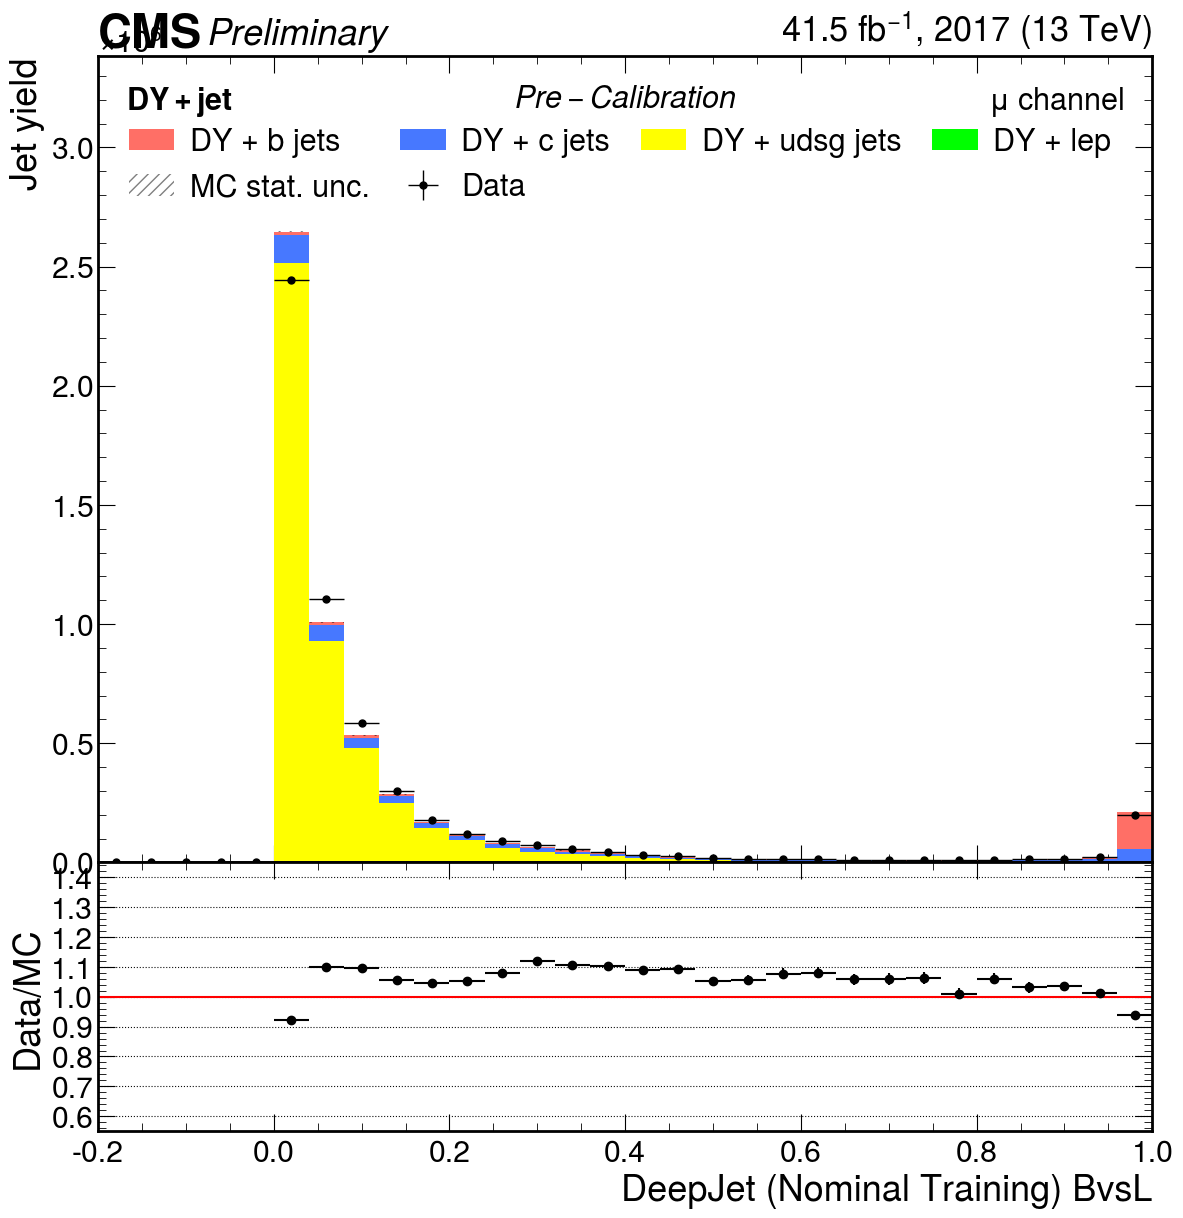

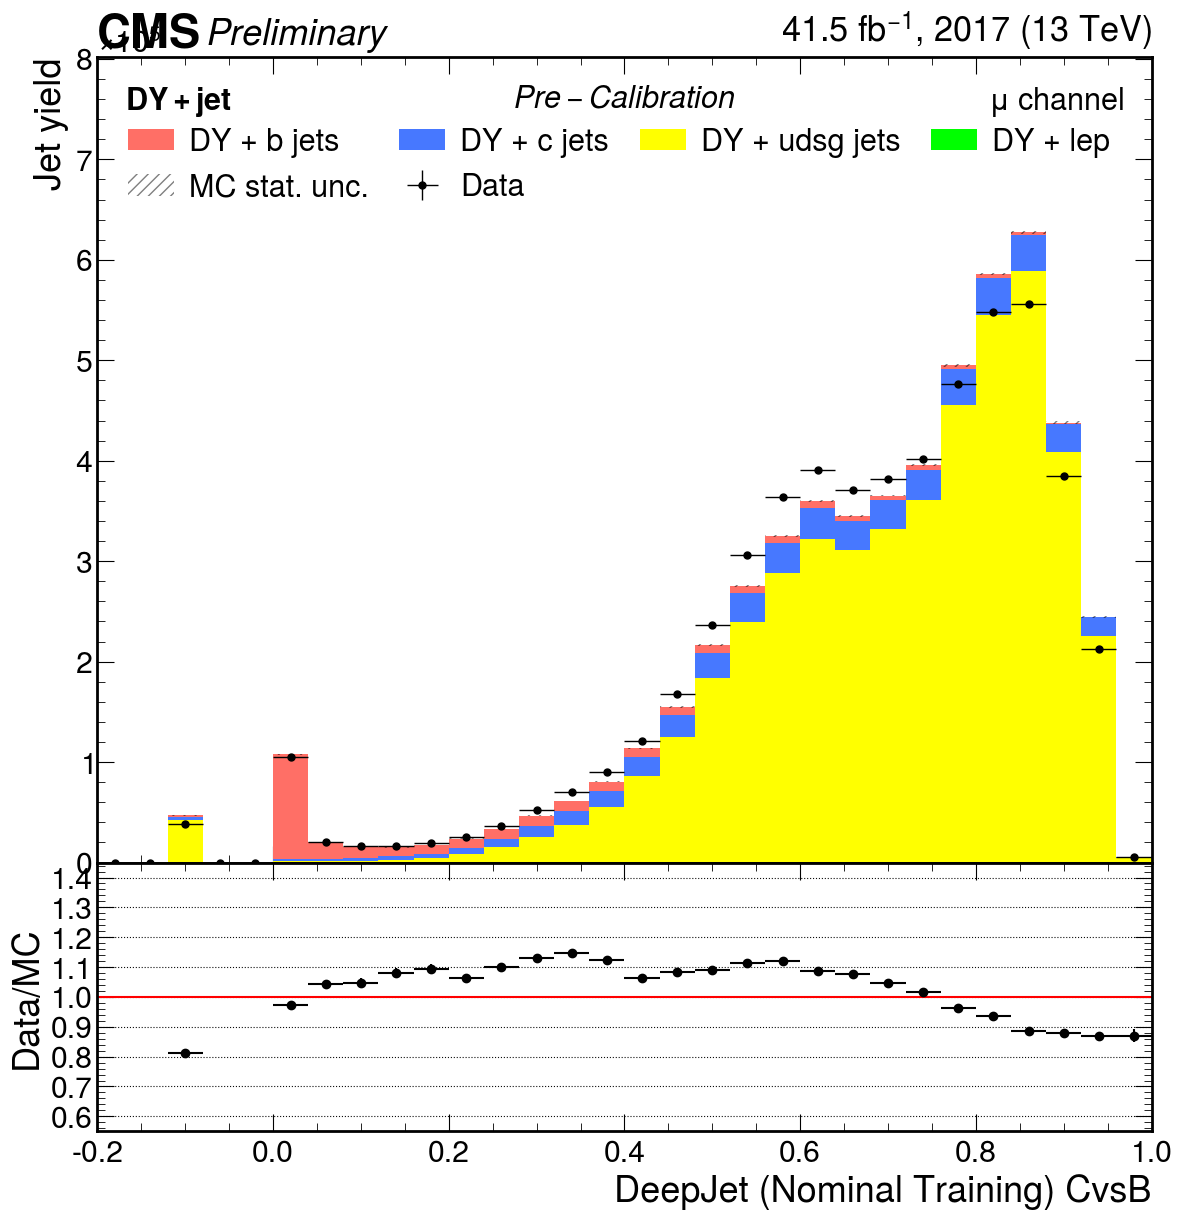

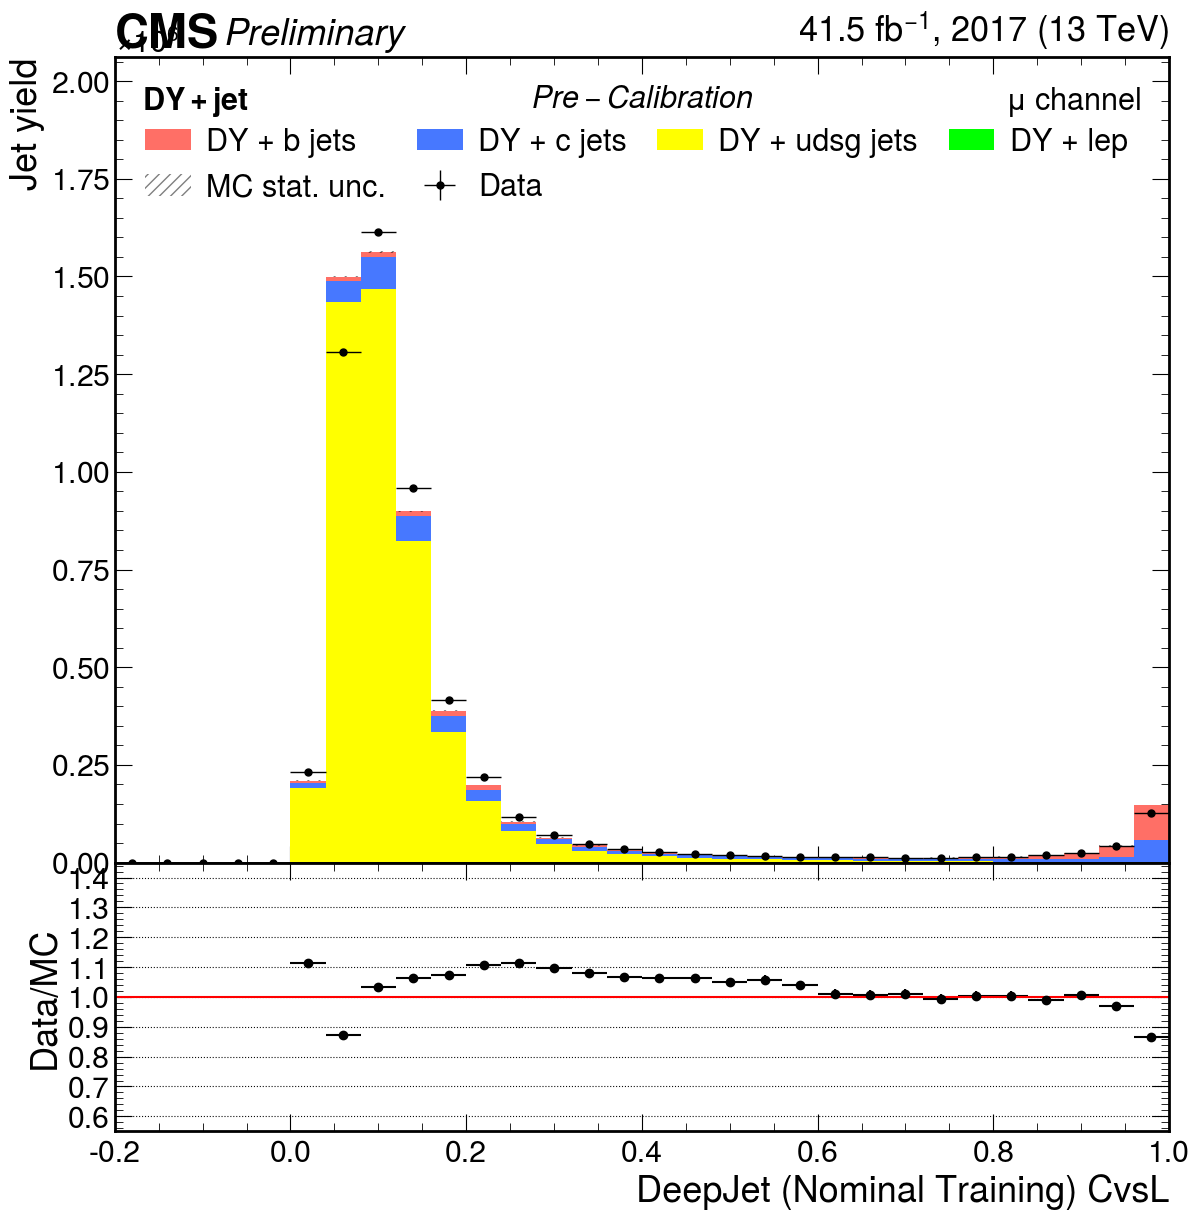

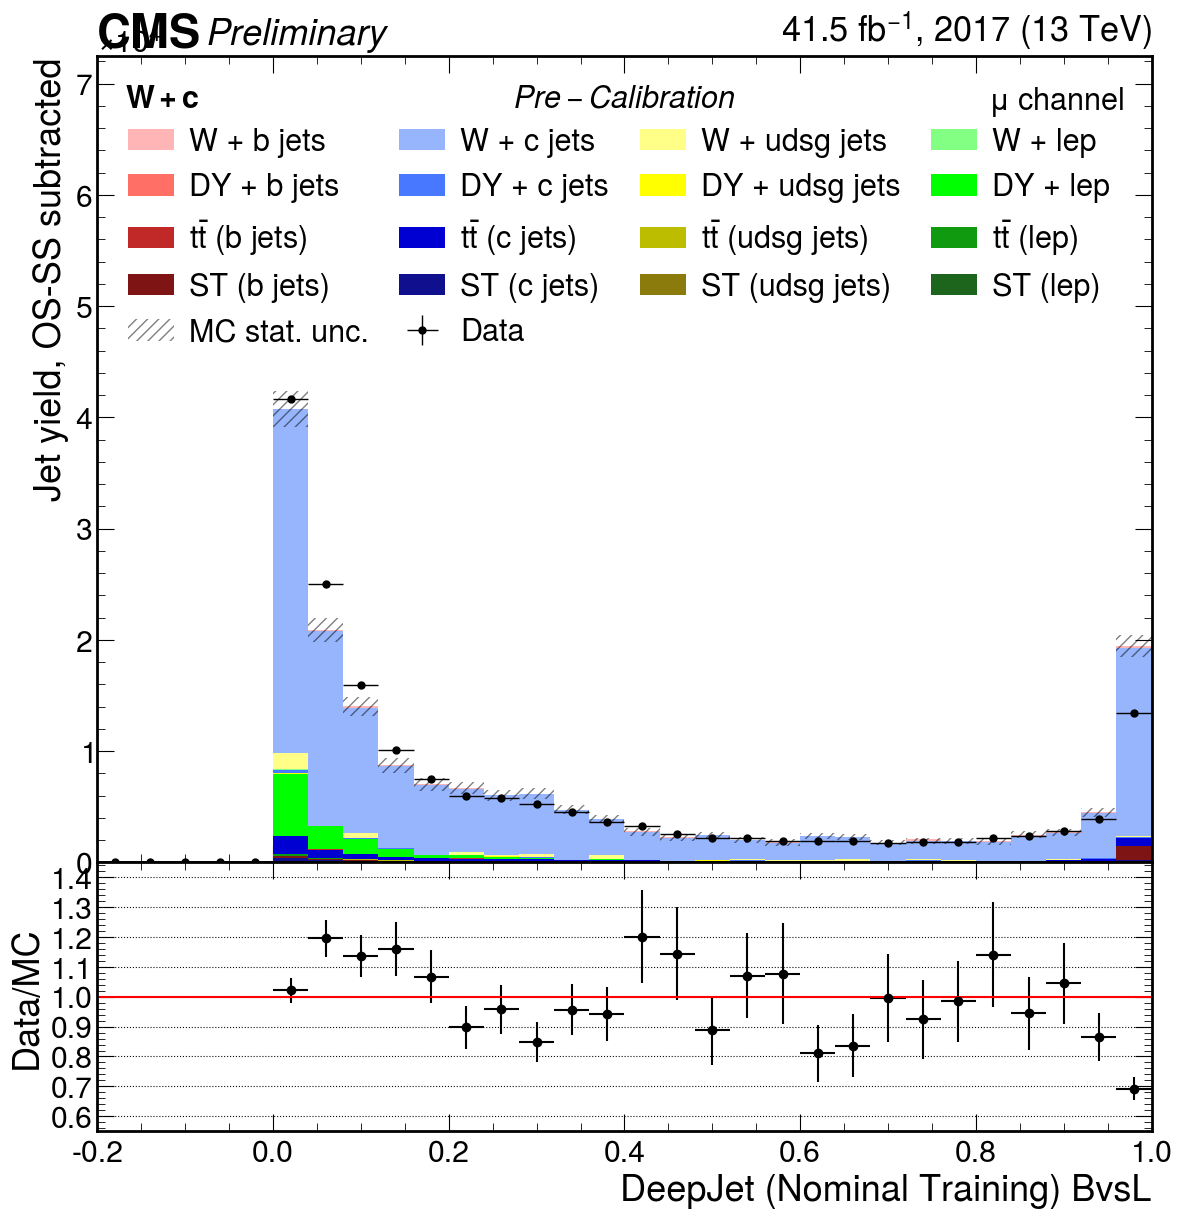

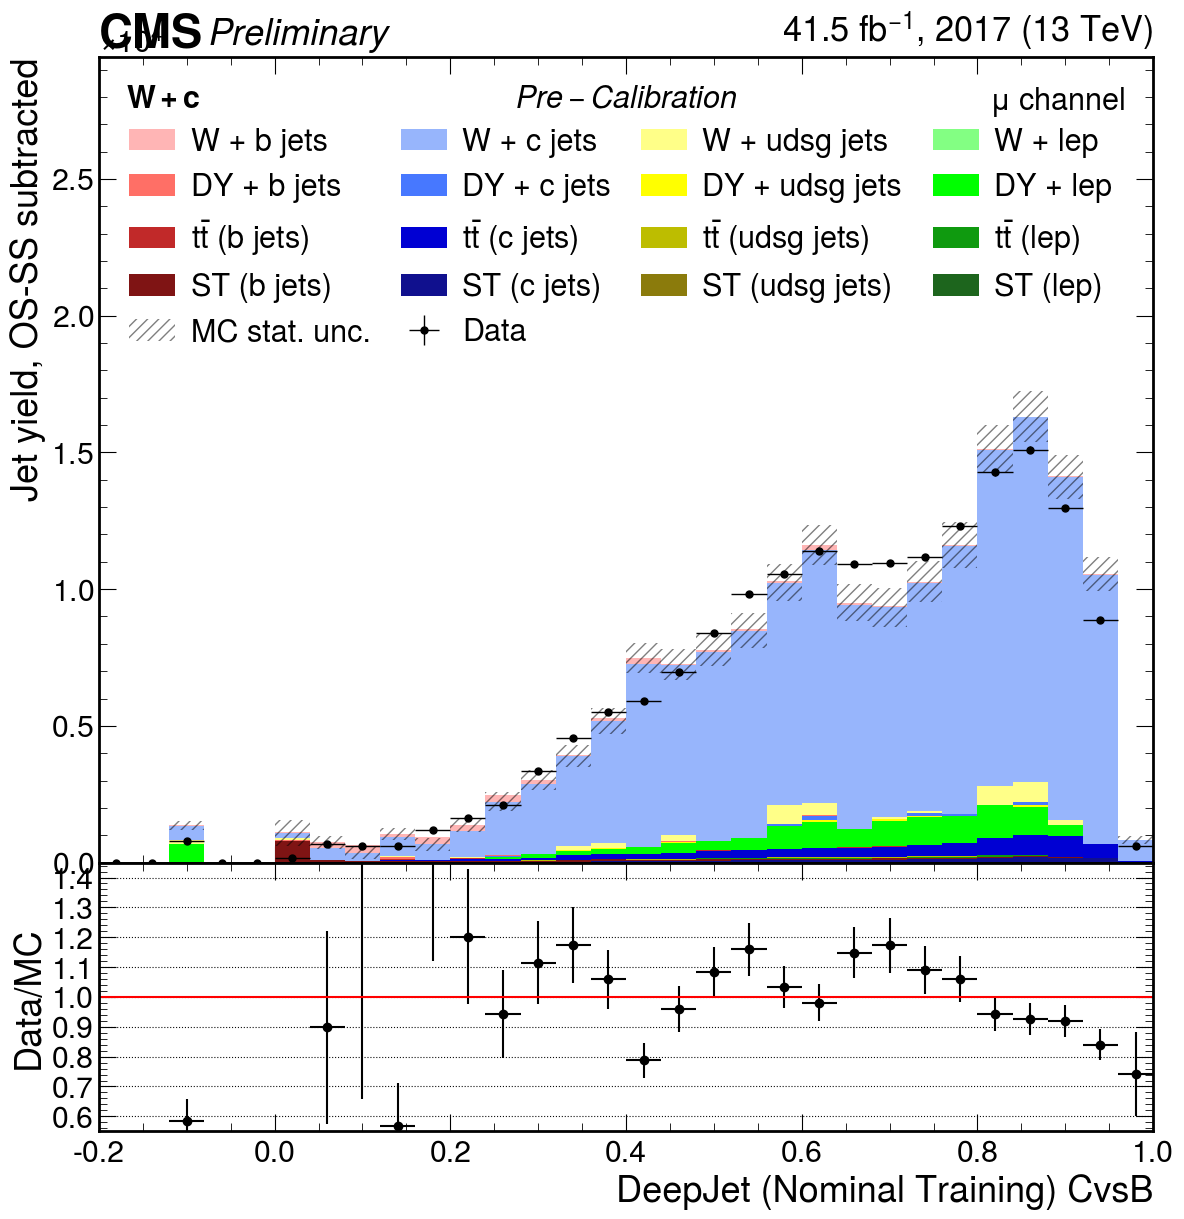

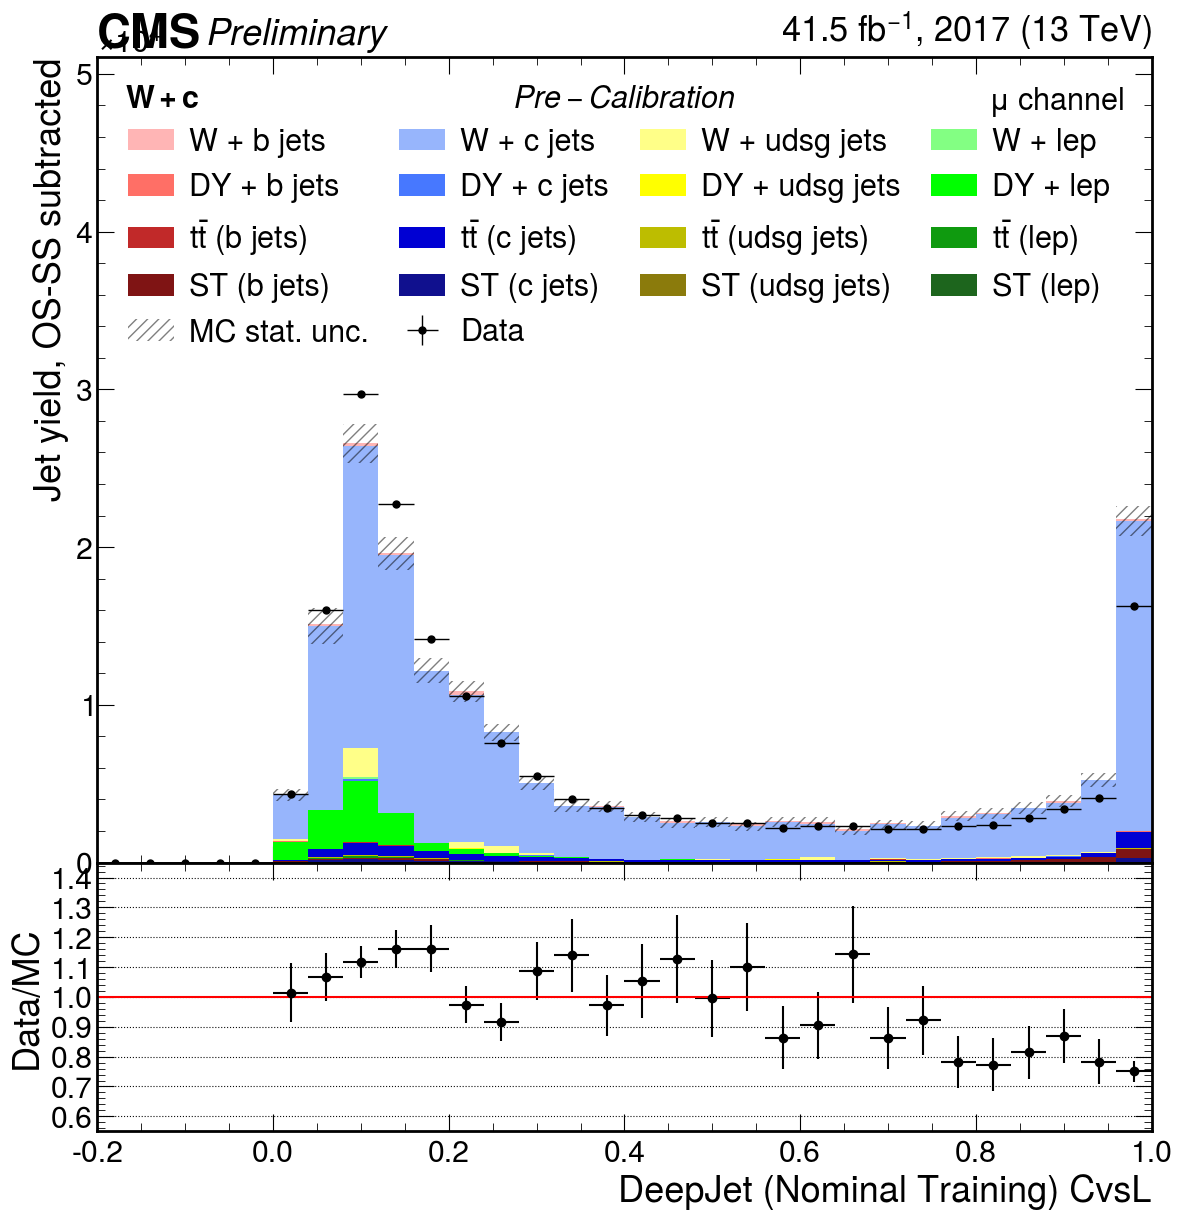

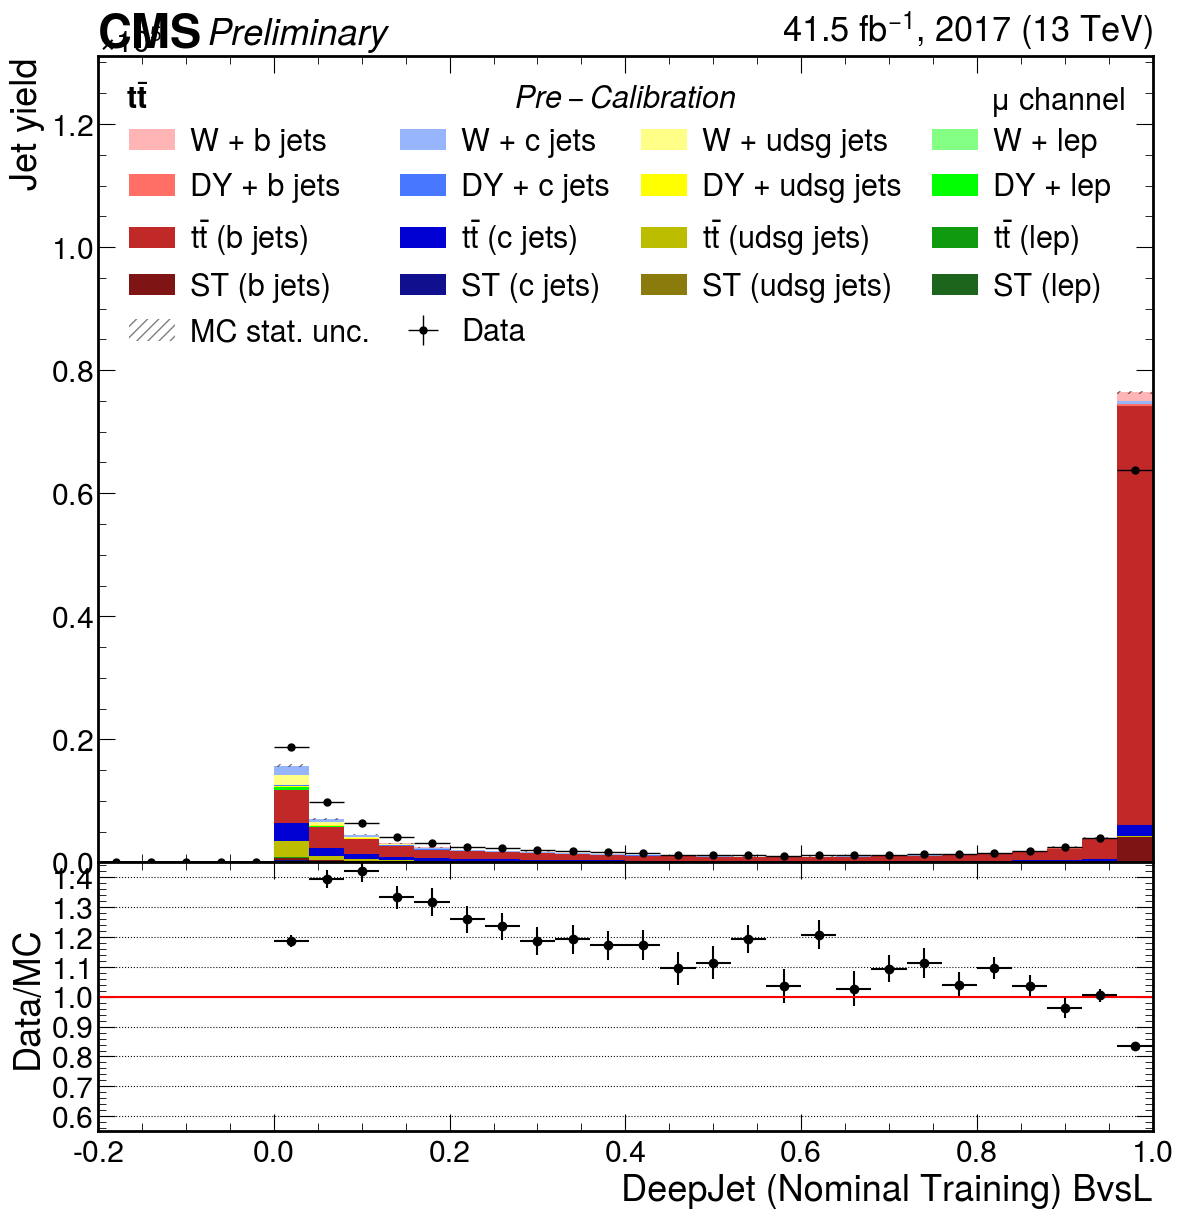

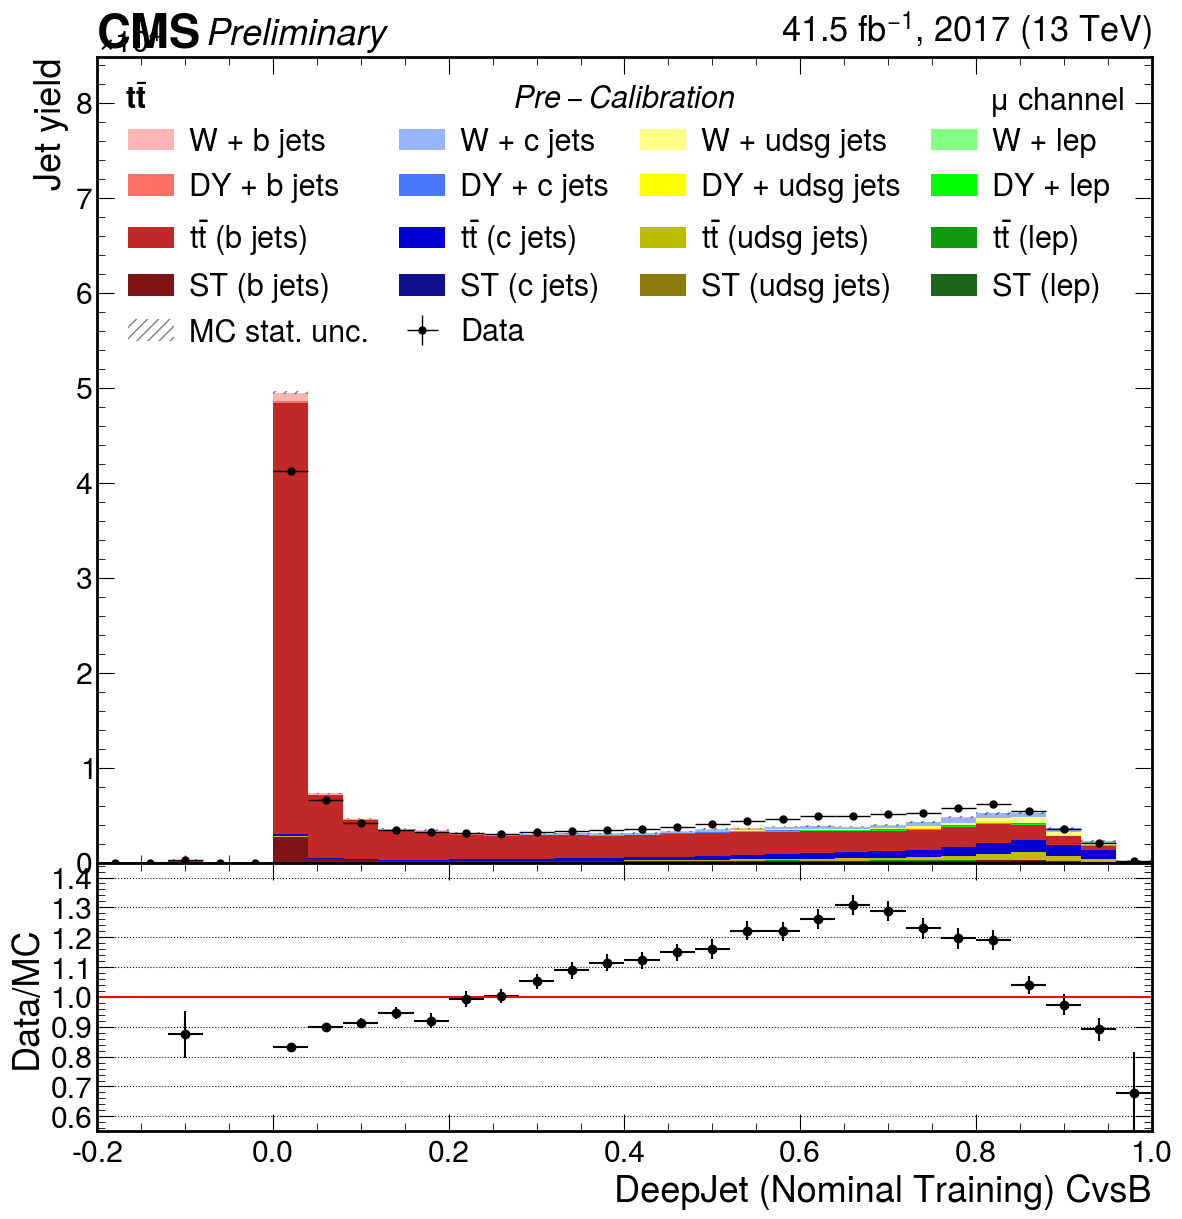

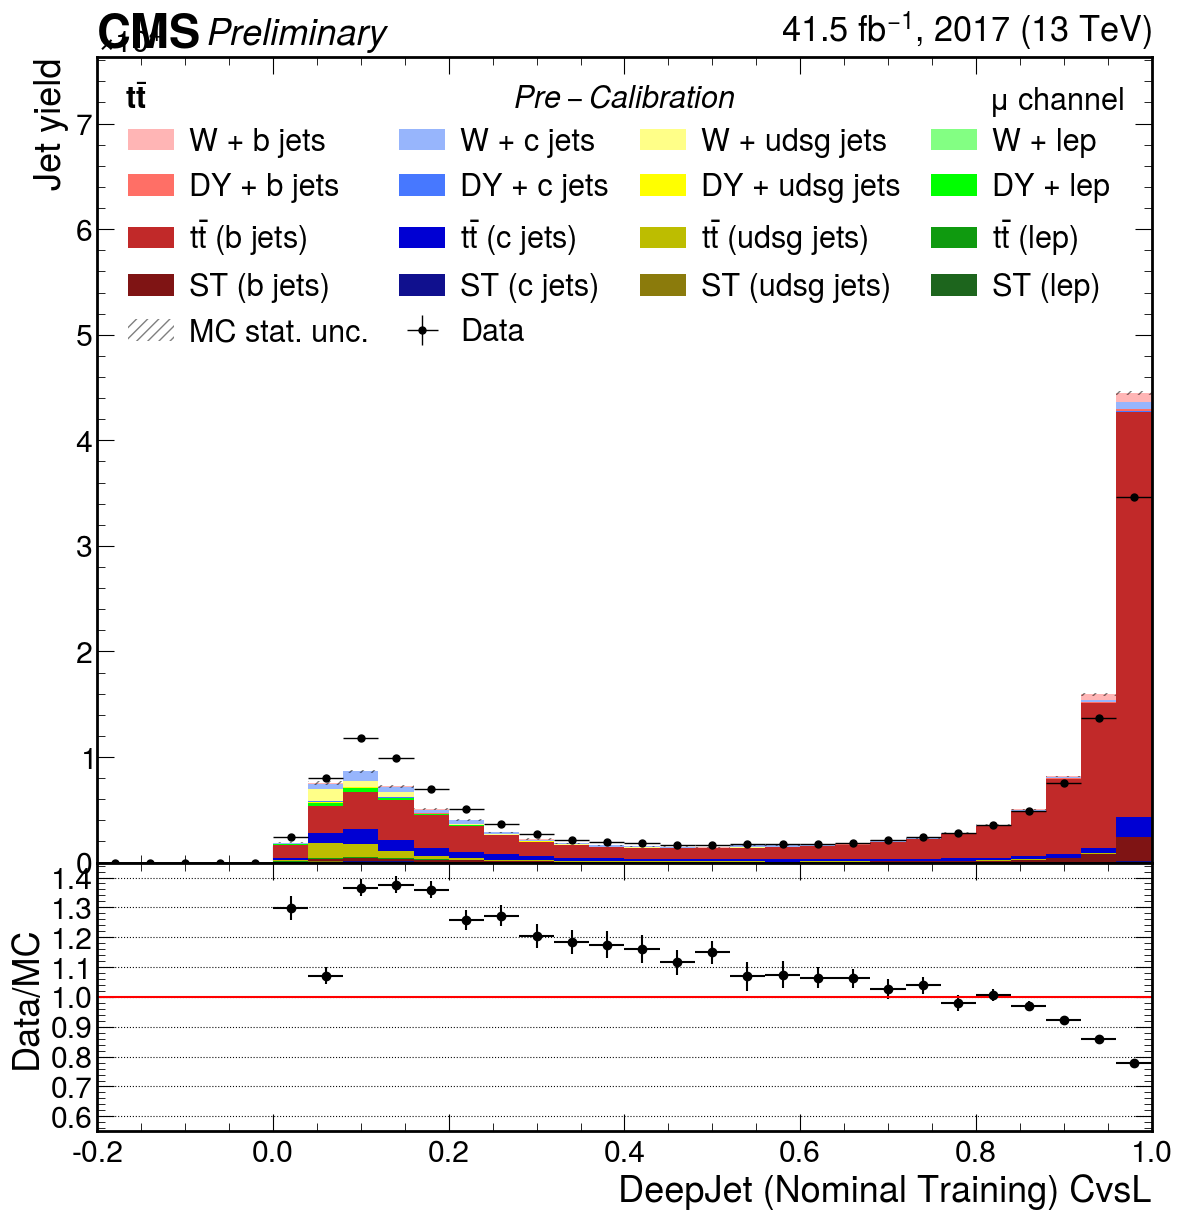

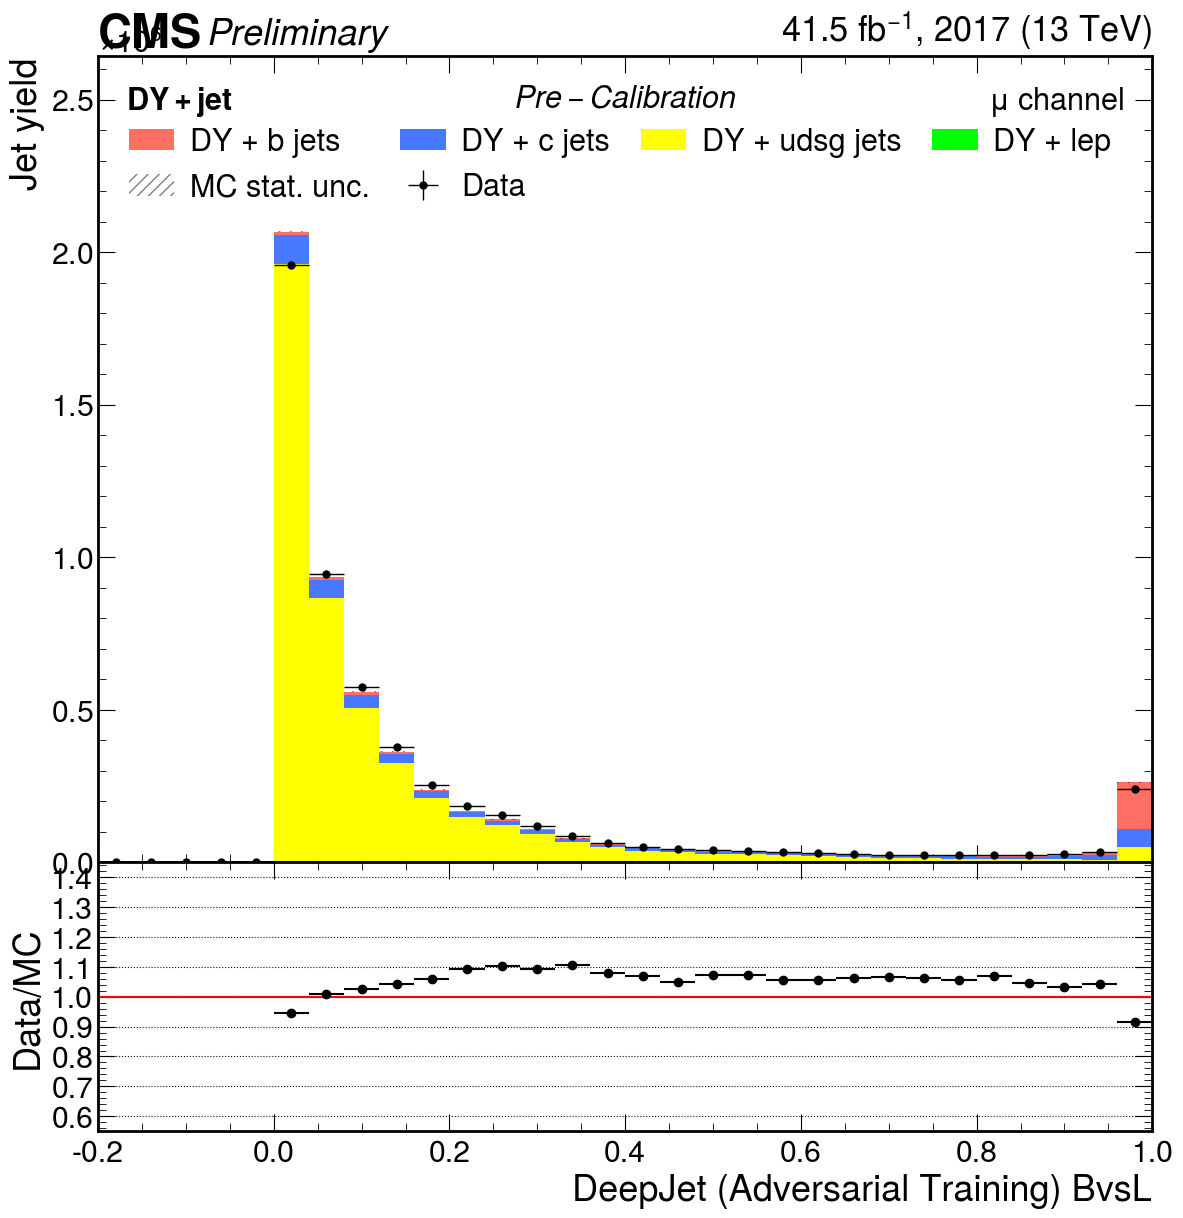

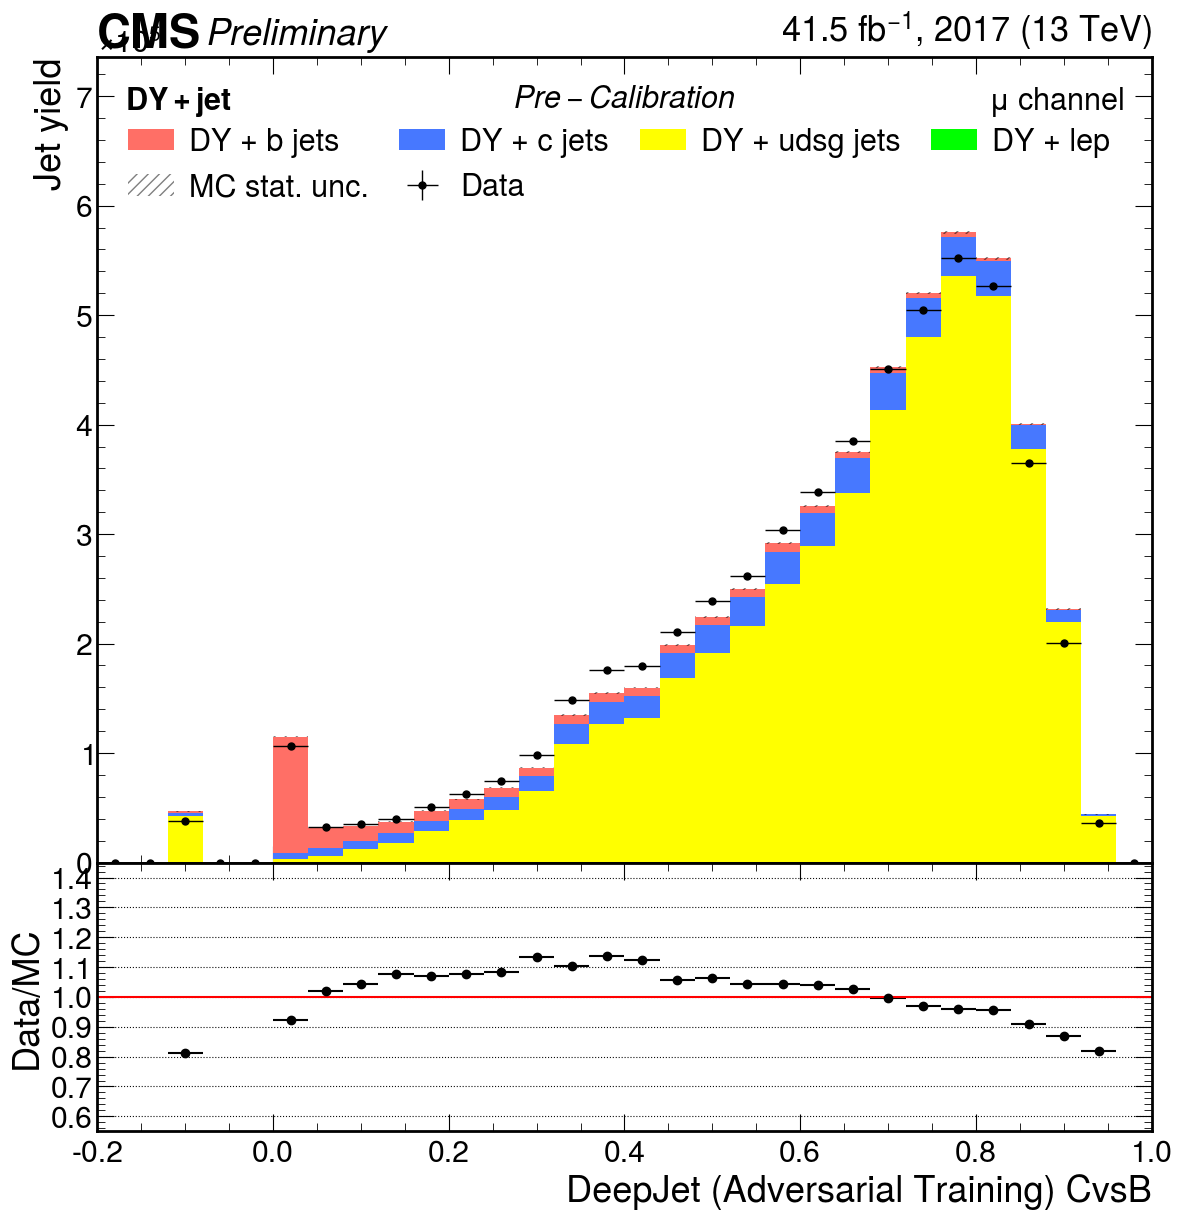

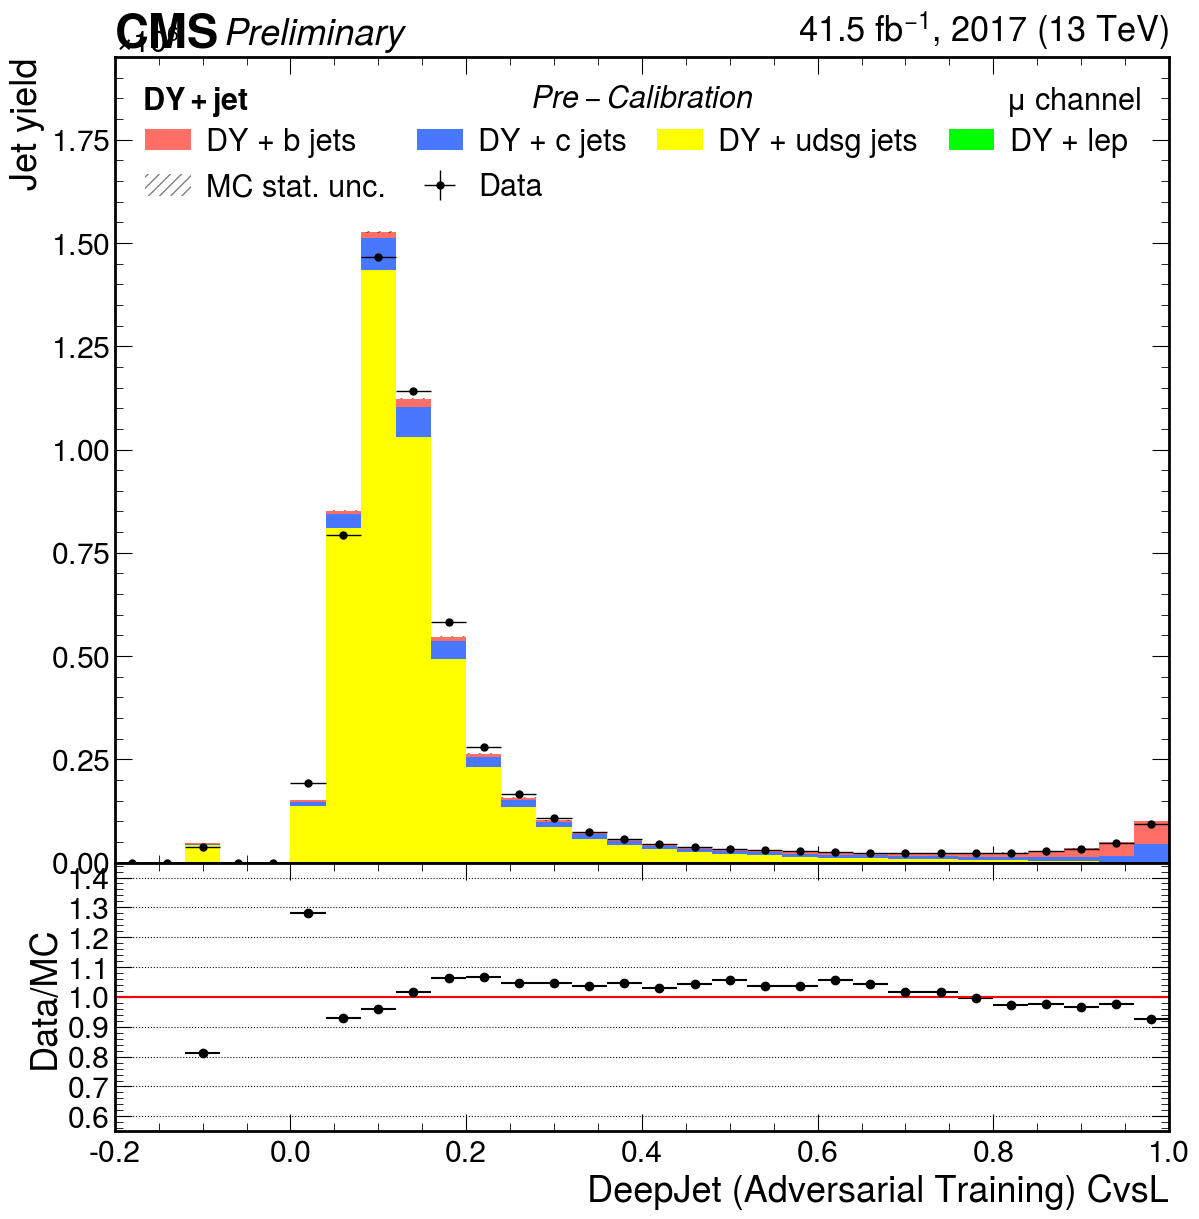

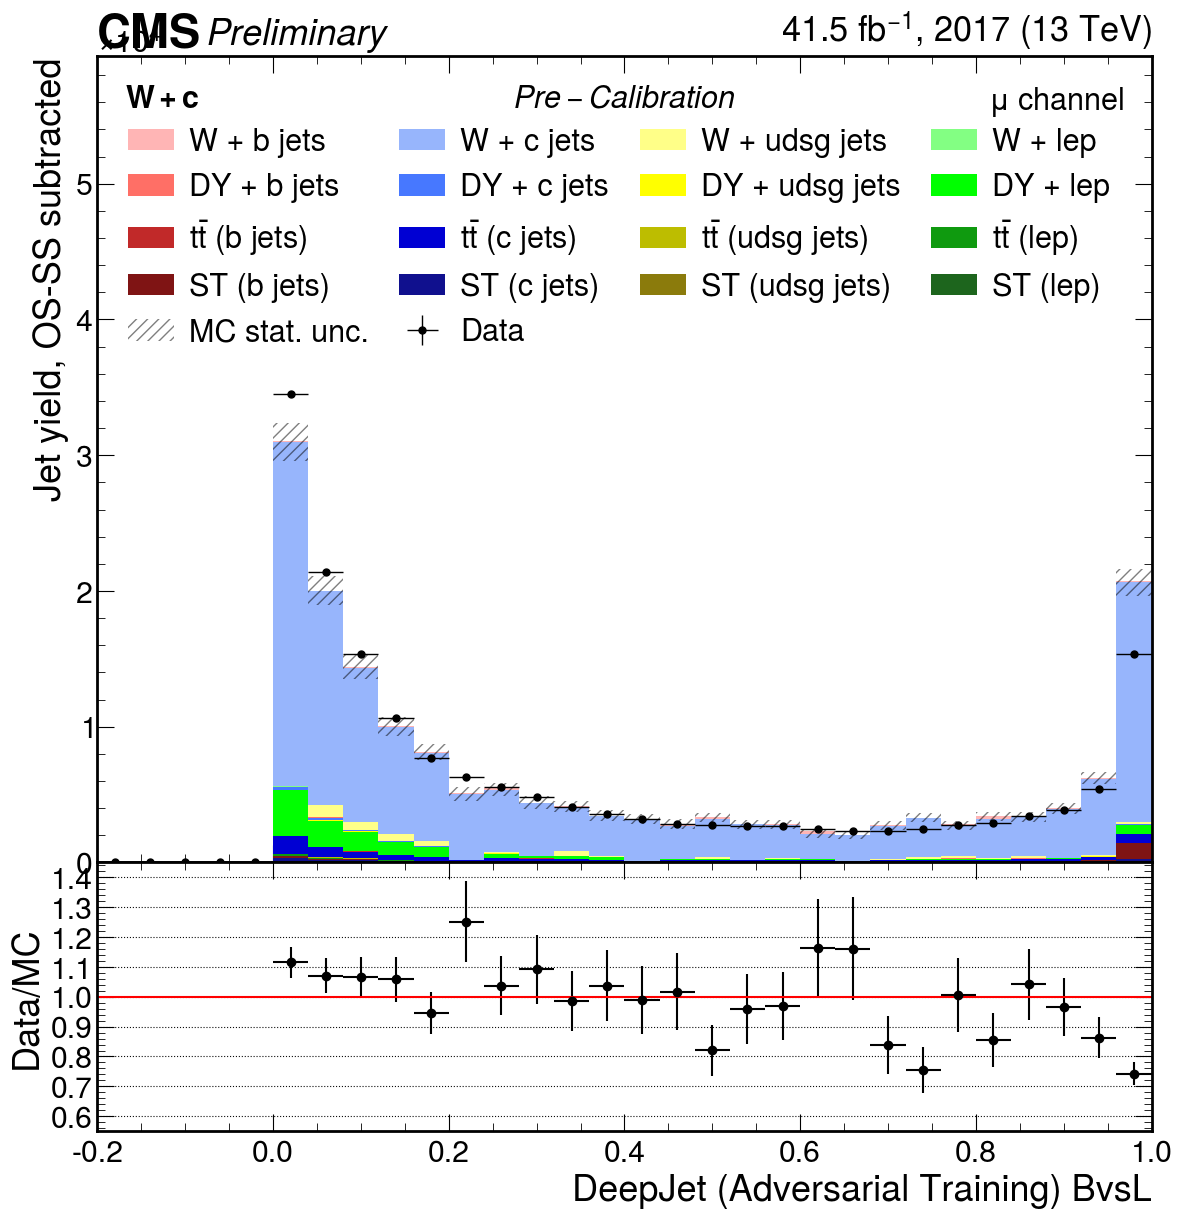

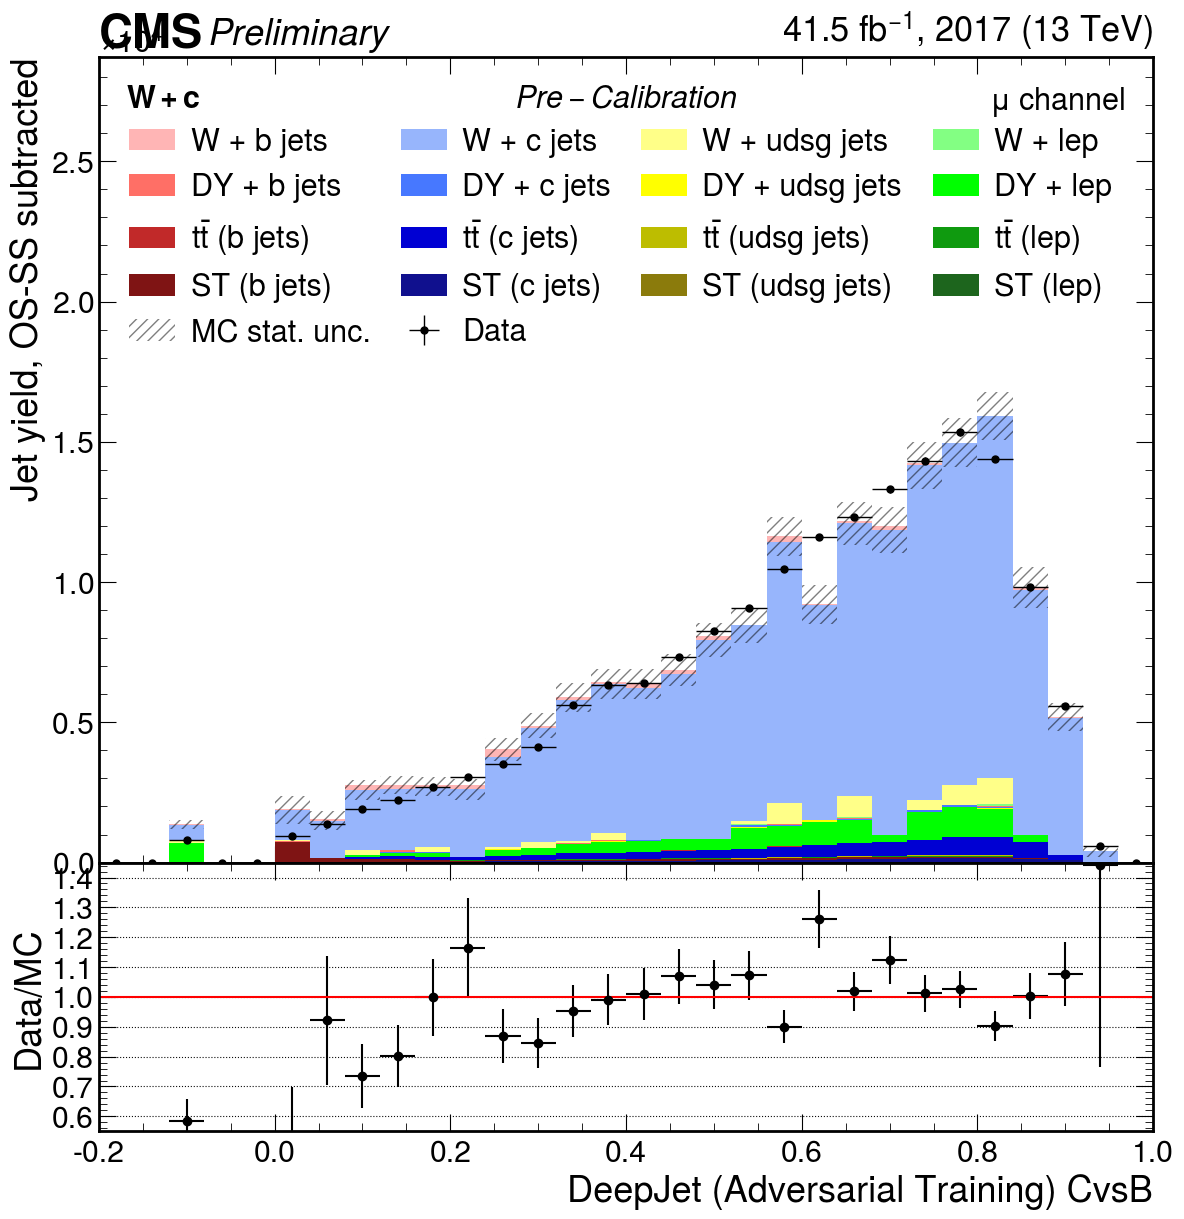

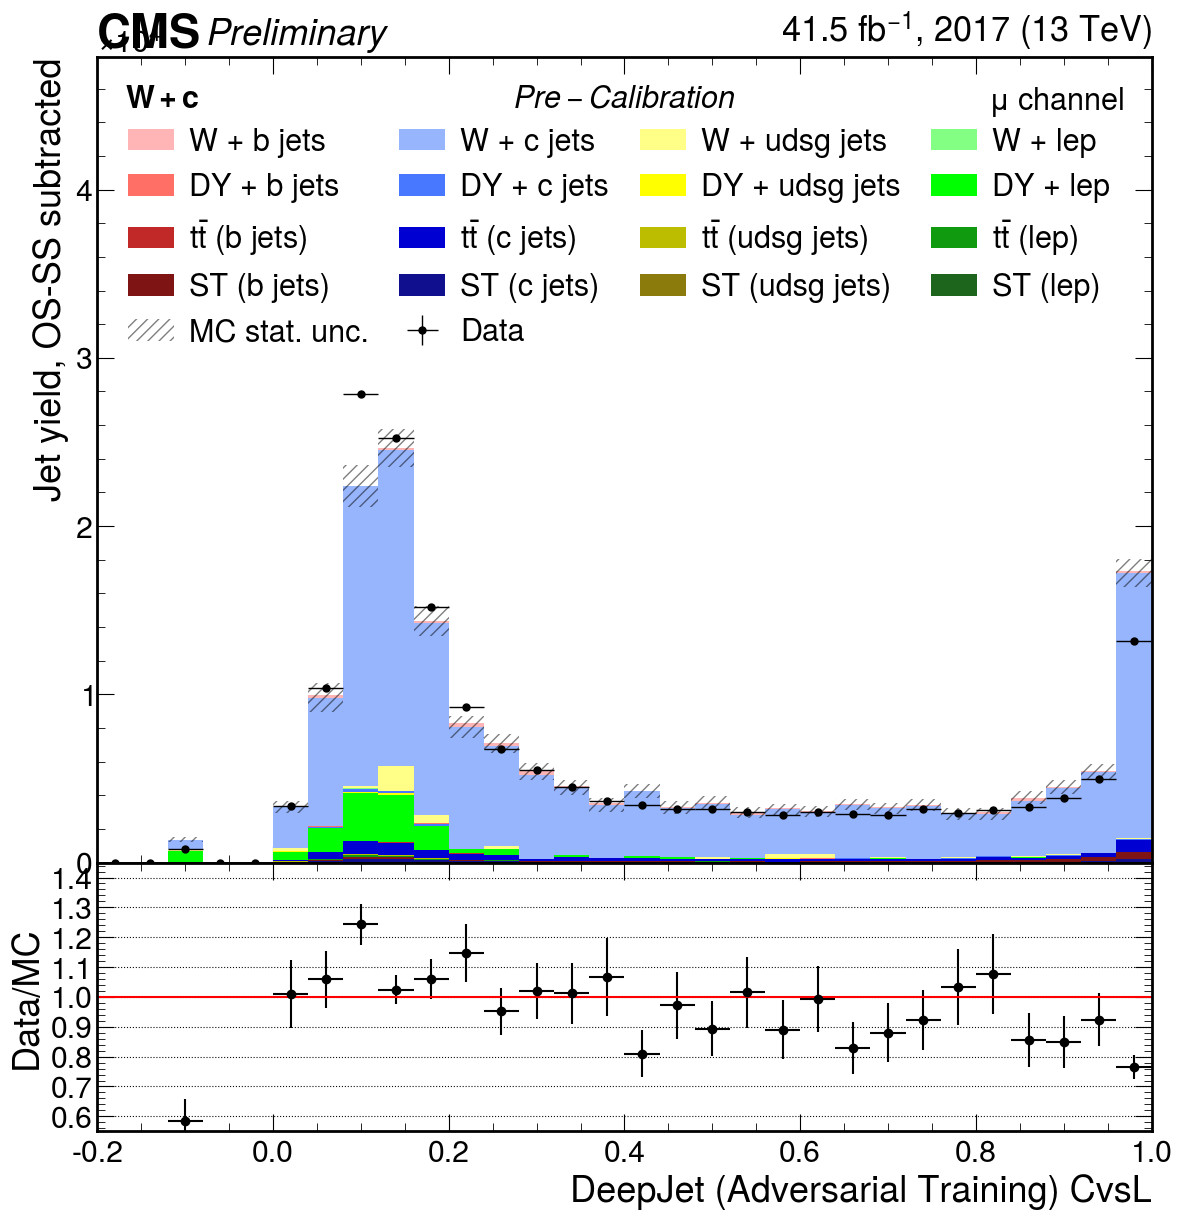

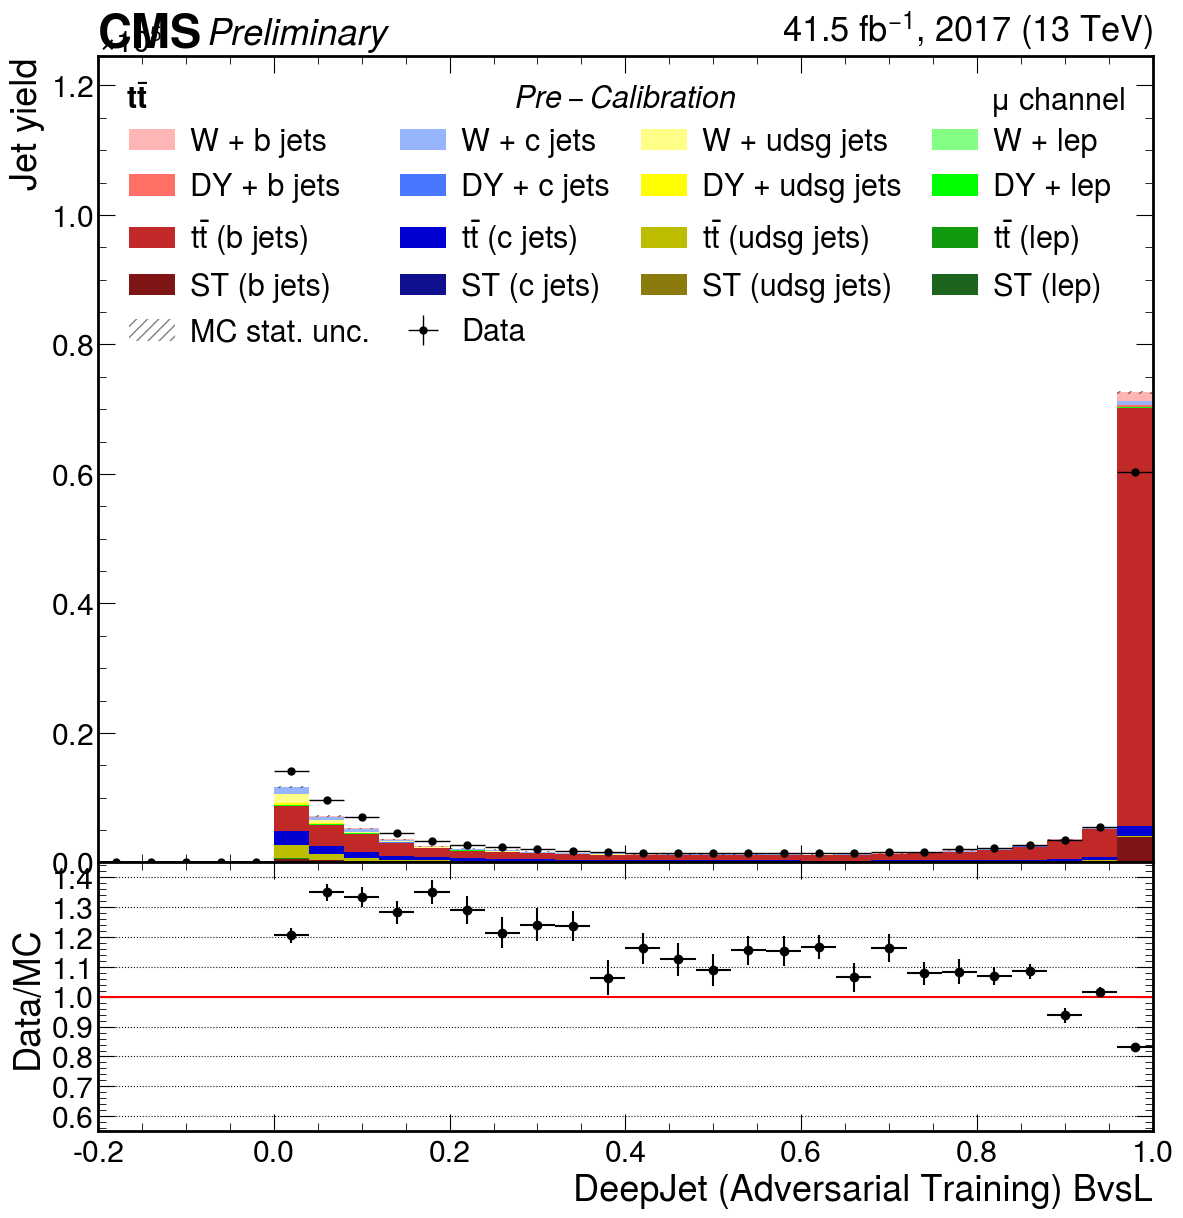

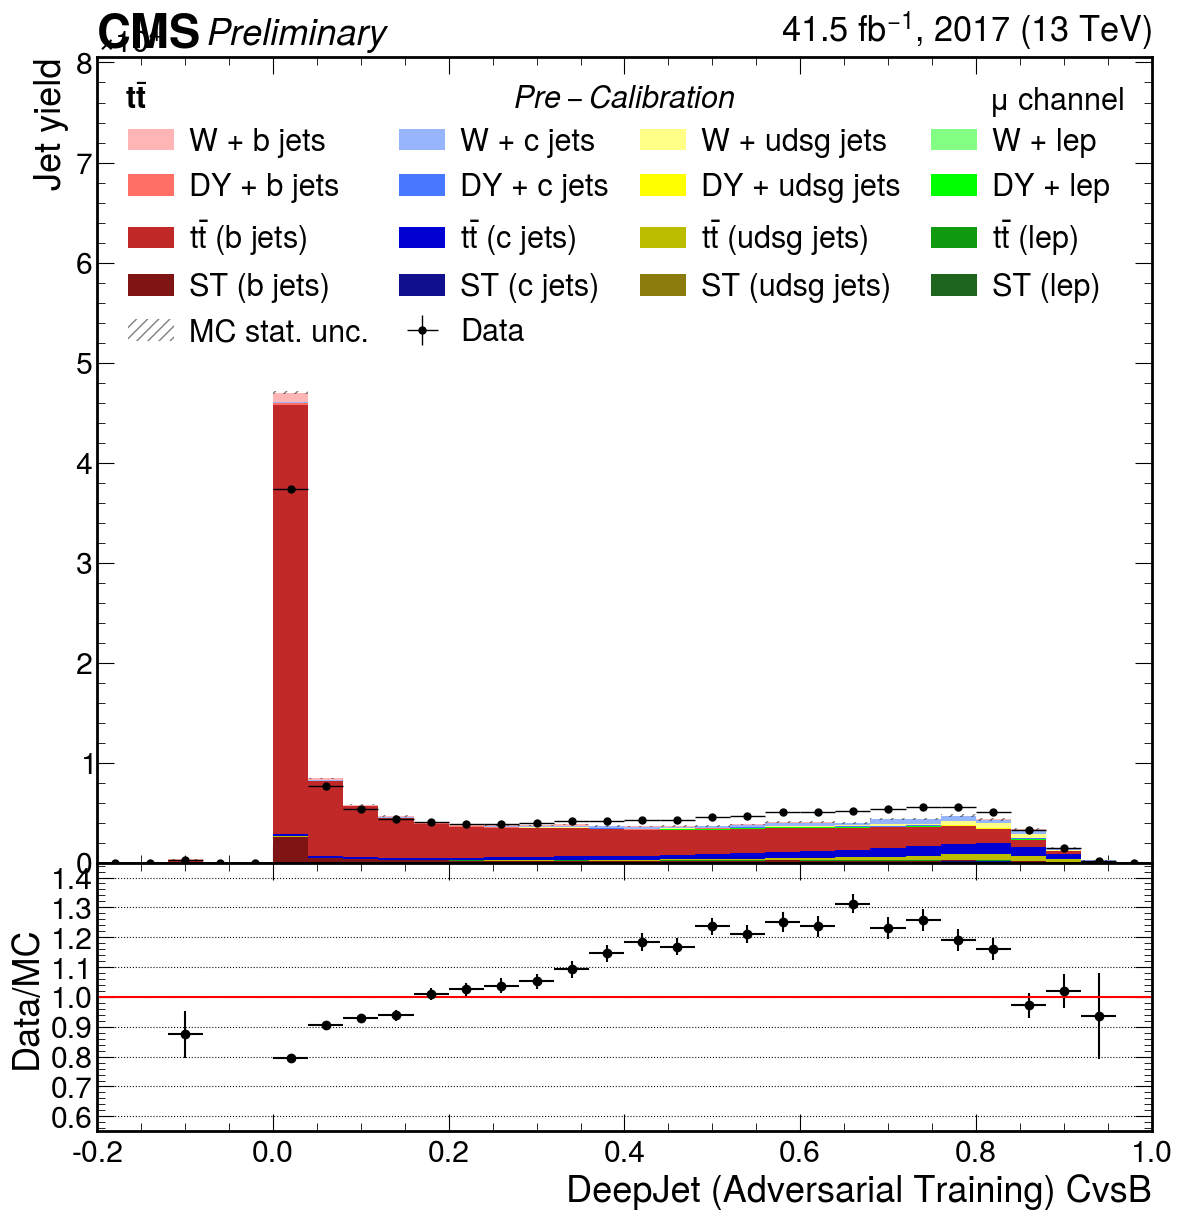

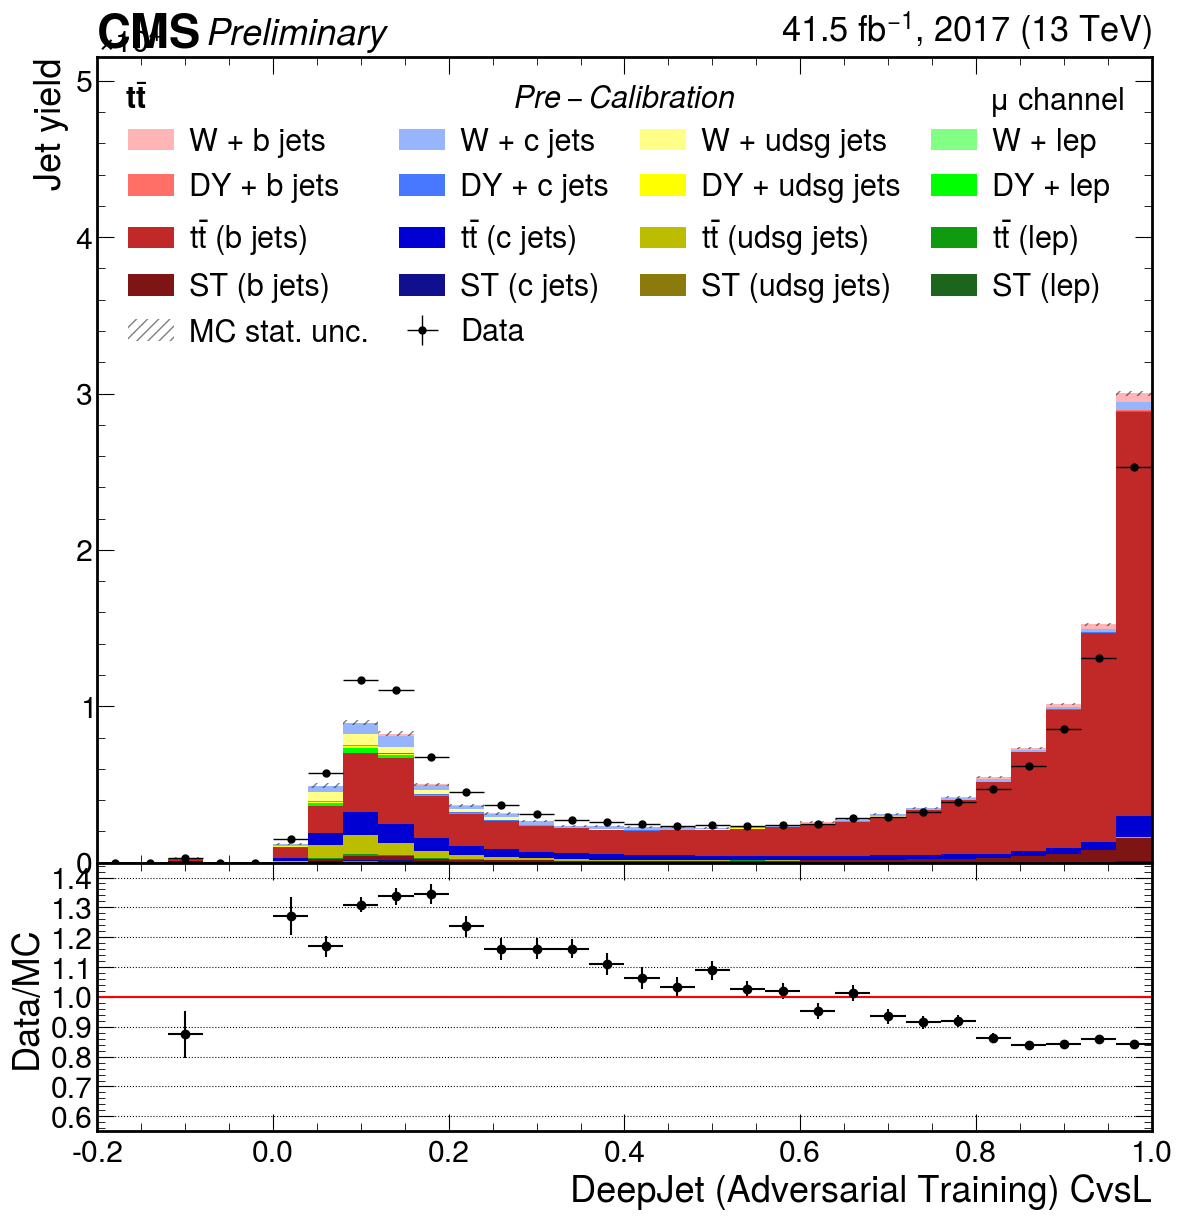

In [52]:
plotRunner('Spandan')

In [53]:
#plotRunner('Andrzej')

In [54]:
#plotRunner('Andrzej_comm')

In [55]:
#plotRunner('merged')

In [56]:
#plotRunner('ignoreLep')

In [57]:
#!tar czf mplHistos3.tar.gz -C /nfs/dust/cms/user/anstein/ctag_condor/ mplHistos_v2

### Calculate KL divergence for adversarial training

In [58]:
epochs = ['best']  # add the ones for which StackPlotter results exist
wms = ['DY_m', 'TT_semim', 'Wc_m']
# DY sel
kl_divs_all_adv_DY          = []
js_divs_all_adv_DY          = []
chi2_all_adv_DY          = []
# Wc sel
kl_divs_all_adv_Wc          = []
js_divs_all_adv_Wc          = []
chi2_all_adv_Wc          = []
# TT sel
kl_divs_all_adv_TT          = []
js_divs_all_adv_TT          = []
chi2_all_adv_TT          = []

kl_holder_adv = {'DY_m' : kl_divs_all_adv_DY, 'Wc_m' : kl_divs_all_adv_Wc, 'TT_semim' : kl_divs_all_adv_TT}
js_holder_adv = {'DY_m' : js_divs_all_adv_DY, 'Wc_m' : js_divs_all_adv_Wc, 'TT_semim' : js_divs_all_adv_TT}
chi2_holder_adv = {'DY_m' : chi2_all_adv_DY, 'Wc_m' : chi2_all_adv_Wc, 'TT_semim' : chi2_all_adv_TT}
#kl_divs_all_adv_DY_datadata = []
#kl_divs_all_adv_DY_simsim   = []
#data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#data_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
for j,wm in enumerate(wms):
    if wm == 'DY_m':
        indexjet = '0'
    else:
        indexjet = 'muJet_idx'
    for i,e in enumerate(epochs):
        kl_divs_adv          = []
        js_divs_adv          = []
        chi2_adv          = []
        #kl_divs_adv_datadata = []
        #kl_divs_adv_simsim   = []
        for disc in ['BvsL', 'CvsB', 'CvsL']:  # select those that exist for paths listed below
            if True:
                # data to MC
                #print(ana_outdir_adv_dict[e])
                histo = uproot.open(ana_outdir_adv_dict[e]+f'/output_2017_PFNano_central/{wm}_jet_CustomADV{epoch_letter_dict[e]}{disc}_{indexjet}_.root')

                num, denom = histo['Data'].values(), histo['MCSum'].values()
                num_num, denom_num = num, denom
                #print(num, denom)
                denom[(denom == 0) & (num != 0)] = 0.00001
                where_num_or_denom_negative = (denom < 0) | (num < 0)
                num[where_num_or_denom_negative] = 0
                denom[where_num_or_denom_negative] = 0
                #print(num, denom)
                this_kl_a = entropy([v for v in num] , qk=[v for v in denom])
                kl_divs_adv.append(this_kl_a)

                #num, denom = histo['Data'].values(), histo['MCSum'].values()
                this_js = jsdiv(num, denom, normalize_first=True)
                this_chi2 = chi2(num, denom, normalize_first=True)

                js_divs_adv.append(this_js)
                chi2_adv.append(this_chi2)

                '''
                # data / data and MC / MC
                #print(data_disc_histo_dict[disc])
                #print(data_disc_histo_dict)
                #print(disc)
                if i > 0:
                    # data / data (this epoch: num_num / previous epoch: look up in dictionary)                
                    data_disc_histo_dict[disc][(data_disc_histo_dict[disc] == 0) & (num_num != 0)] = 0.00001
                    where_num_or_denom_negative = (data_disc_histo_dict[disc] < 0) | (num_num < 0)
                    num_num[where_num_or_denom_negative] = 0
                    data_disc_histo_dict[disc][where_num_or_denom_negative] = 0

                    # mc / mc (this epoch: denom_num / previous epoch: look up in dictionary)                
                    sim_disc_histo_dict[disc][(sim_disc_histo_dict[disc] == 0) & (denom_num != 0)] = 0.00001
                    where_num_or_denom_negative = (sim_disc_histo_dict[disc] < 0) | (denom_num < 0)
                    denom_num[where_num_or_denom_negative] = 0
                    sim_disc_histo_dict[disc][where_num_or_denom_negative] = 0


                    kl_divs_adv_datadata.append(entropy([v for v in num_num] , qk=data_disc_histo_dict[disc]))
                    kl_divs_adv_simsim.append(entropy([v for v in denom_num] , qk=sim_disc_histo_dict[disc]))
                
                # store this epoch's histogram for the respective variable in the dictionary (makes comparing with previous epoch possible)
                data_disc_histo_dict[disc] = num
                sim_disc_histo_dict[disc] = denom
                '''
            if False:
                kl_divs_adv.append(np.NaN)

        #print(kl_divs_adv)
        kl_holder_adv[wm].append(kl_divs_adv)
        js_holder_adv[wm].append(js_divs_adv)
        chi2_holder_adv[wm].append(chi2_adv)
        '''
        if i > 0:
            kl_divs_all_adv_DY_datadata.append(kl_divs_adv_datadata)
            kl_divs_all_adv_DY_simsim.append(kl_divs_adv_simsim)
        '''
    #kl_divs_all_adv_DY = np.array(kl_divs_all_adv_DY)
    #kl_divs_all_adv_DY_datadata = np.array(kl_divs_all_adv_DY_datadata)
    #kl_divs_all_adv_DY_simsim = np.array(kl_divs_all_adv_DY_simsim)

    #print(kl_divs_all_adv_DY)
    print(js_divs_all_adv_DY)
    #print(chi2_all_adv_DY)
    #print(kl_divs_all_adv_Wc)
    print(js_divs_all_adv_Wc)
    #print(chi2_all_adv_Wc)
   # print(kl_divs_all_adv_TT)
    print(js_divs_all_adv_TT)
    #print(chi2_all_adv_TT)
    #print(kl_divs_all_adv_DY_datadata)
    #print(kl_divs_all_adv_DY_simsim)
    print()

[[0.00037523313457378006, 0.0006190451974245836, 0.0005611414012928297]]
[]
[]

[[0.00037523313457378006, 0.0006190451974245836, 0.0005611414012928297]]
[]
[[0.004627734079790169, 0.004058816210416398, 0.0040706759803375275]]

[[0.00037523313457378006, 0.0006190451974245836, 0.0005611414012928297]]
[[0.002375862204091684, 0.0019868216305777885, 0.0025820995966759413]]
[[0.004627734079790169, 0.004058816210416398, 0.0040706759803375275]]



/tmp/ipykernel_4594/3477186723.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_4594/1550839093.py:8: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in ((P-Q)**2 / (Q)) if not np.isnan(v)])


In [59]:
epochs = ['best']  # add the ones for which StackPlotter results exist
wms = ['DY_m', 'TT_semim', 'Wc_m']
# DY sel
kl_divs_all_basic_DY          = []
js_divs_all_basic_DY          = []
chi2_all_basic_DY          = []
# Wc sel
kl_divs_all_basic_Wc          = []
js_divs_all_basic_Wc          = []
chi2_all_basic_Wc          = []
# TT sel
kl_divs_all_basic_TT          = []
js_divs_all_basic_TT          = []
chi2_all_basic_TT          = []

kl_holder_basic = {'DY_m' : kl_divs_all_basic_DY, 'Wc_m' : kl_divs_all_basic_Wc, 'TT_semim' : kl_divs_all_basic_TT}
js_holder_basic = {'DY_m' : js_divs_all_basic_DY, 'Wc_m' : js_divs_all_basic_Wc, 'TT_semim' : js_divs_all_basic_TT}
chi2_holder_basic = {'DY_m' : chi2_all_basic_DY, 'Wc_m' : chi2_all_basic_Wc, 'TT_semim' : chi2_all_basic_TT}
#kl_divs_all_basic_DY_datadata = []
#kl_divs_all_basic_DY_simsim   = []
#data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#data_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
for j,wm in enumerate(wms):
    if wm == 'DY_m':
        indexjet = '0'
    else:
        indexjet = 'muJet_idx'
    for i,e in enumerate(epochs):
        kl_divs_basic          = []
        js_divs_basic          = []
        chi2_basic          = []
        #kl_divs_basic_datadata = []
        #kl_divs_basic_simsim   = []
        for disc in ['BvsL', 'CvsB', 'CvsL']:  # select those that exist for paths listed below
            if True:
                # data to MC
                #print(ana_outdir_basic_dict[e])
                histo = uproot.open(ana_outdir_basic_dict[e]+f'/output_2017_PFNano_central/{wm}_jet_Custom{epoch_letter_dict[e]}{disc}_{indexjet}_.root')

                num, denom = histo['Data'].values(), histo['MCSum'].values()
                num_num, denom_num = num, denom
                #print(num, denom)
                denom[(denom == 0) & (num != 0)] = 0.00001
                where_num_or_denom_negative = (denom < 0) | (num < 0)
                num[where_num_or_denom_negative] = 0
                denom[where_num_or_denom_negative] = 0
                #print(num, denom)
                this_kl_a = entropy([v for v in num] , qk=[v for v in denom])
                kl_divs_basic.append(this_kl_a)

                #num, denom = histo['Data'].values(), histo['MCSum'].values()
                this_js = jsdiv(num, denom, normalize_first=True)
                this_chi2 = chi2(num, denom, normalize_first=True)

                js_divs_basic.append(this_js)
                chi2_basic.append(this_chi2)

                '''
                # data / data and MC / MC
                #print(data_disc_histo_dict[disc])
                #print(data_disc_histo_dict)
                #print(disc)
                if i > 0:
                    # data / data (this epoch: num_num / previous epoch: look up in dictionary)                
                    data_disc_histo_dict[disc][(data_disc_histo_dict[disc] == 0) & (num_num != 0)] = 0.00001
                    where_num_or_denom_negative = (data_disc_histo_dict[disc] < 0) | (num_num < 0)
                    num_num[where_num_or_denom_negative] = 0
                    data_disc_histo_dict[disc][where_num_or_denom_negative] = 0

                    # mc / mc (this epoch: denom_num / previous epoch: look up in dictionary)                
                    sim_disc_histo_dict[disc][(sim_disc_histo_dict[disc] == 0) & (denom_num != 0)] = 0.00001
                    where_num_or_denom_negative = (sim_disc_histo_dict[disc] < 0) | (denom_num < 0)
                    denom_num[where_num_or_denom_negative] = 0
                    sim_disc_histo_dict[disc][where_num_or_denom_negative] = 0


                    kl_divs_basic_datadata.append(entropy([v for v in num_num] , qk=data_disc_histo_dict[disc]))
                    kl_divs_basic_simsim.append(entropy([v for v in denom_num] , qk=sim_disc_histo_dict[disc]))
                
                # store this epoch's histogram for the respective variable in the dictionary (makes comparing with previous epoch possible)
                data_disc_histo_dict[disc] = num
                sim_disc_histo_dict[disc] = denom
                '''
            if False:
                kl_divs_basic.append(np.NaN)

        #print(kl_divs_basic)
        kl_holder_basic[wm].append(kl_divs_basic)
        js_holder_basic[wm].append(js_divs_basic)
        chi2_holder_basic[wm].append(chi2_basic)
        '''
        if i > 0:
            kl_divs_all_basic_DY_datadata.append(kl_divs_basic_datadata)
            kl_divs_all_basic_DY_simsim.append(kl_divs_basic_simsim)
        '''
    #kl_divs_all_basic_DY = np.array(kl_divs_all_basic_DY)
    #kl_divs_all_basic_DY_datadata = np.array(kl_divs_all_basic_DY_datadata)
    #kl_divs_all_basic_DY_simsim = np.array(kl_divs_all_basic_DY_simsim)

    print(wm)
    #print(kl_divs_all_basic_DY)
    print(js_divs_all_basic_DY)
    #print(chi2_all_basic_DY)
    #print(kl_divs_all_basic_Wc)
    print(js_divs_all_basic_Wc)
    #print(chi2_all_basic_Wc)
    #print(kl_divs_all_basic_TT)
    print(js_divs_all_basic_TT)
    #print(chi2_all_basic_TT)
    #print(kl_divs_all_basic_DY_datadata)
    #print(kl_divs_all_basic_DY_simsim)
    print()

DY_m
[[0.0008292296877936339, 0.001044544845660487, 0.0010109263067630513]]
[]
[]

TT_semim
[[0.0008292296877936339, 0.001044544845660487, 0.0010109263067630513]]
[]
[[0.004864944733339944, 0.003326602950210492, 0.005590663521433607]]

Wc_m
[[0.0008292296877936339, 0.001044544845660487, 0.0010109263067630513]]
[[0.003063545248656655, 0.003298442006785995, 0.0028799667914592006]]
[[0.004864944733339944, 0.003326602950210492, 0.005590663521433607]]



/tmp/ipykernel_4594/3477186723.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_4594/1550839093.py:8: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in ((P-Q)**2 / (Q)) if not np.isnan(v)])


In [60]:
print(this_js)
print(js_divs_basic)
print(js_holder_basic)

0.0028799667914592006
[0.003063545248656655, 0.003298442006785995, 0.0028799667914592006]
{'DY_m': [[0.0008292296877936339, 0.001044544845660487, 0.0010109263067630513]], 'Wc_m': [[0.003063545248656655, 0.003298442006785995, 0.0028799667914592006]], 'TT_semim': [[0.004864944733339944, 0.003326602950210492, 0.005590663521433607]]}


In [61]:
xses = ['BvsL', 'CvsB', 'CvsL']

In [62]:
[f'{f:f}' for f in js_divs_all_basic_DY[0]+js_divs_all_basic_Wc[0]+js_divs_all_basic_TT[0]]

['0.000829',
 '0.001045',
 '0.001011',
 '0.003064',
 '0.003298',
 '0.002880',
 '0.004865',
 '0.003327',
 '0.005591']

In [63]:
[f'{f:f}' for f in js_divs_all_adv_DY[0]+js_divs_all_adv_Wc[0]+js_divs_all_adv_TT[0]]

['0.000375',
 '0.000619',
 '0.000561',
 '0.002376',
 '0.001987',
 '0.002582',
 '0.004628',
 '0.004059',
 '0.004071']

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

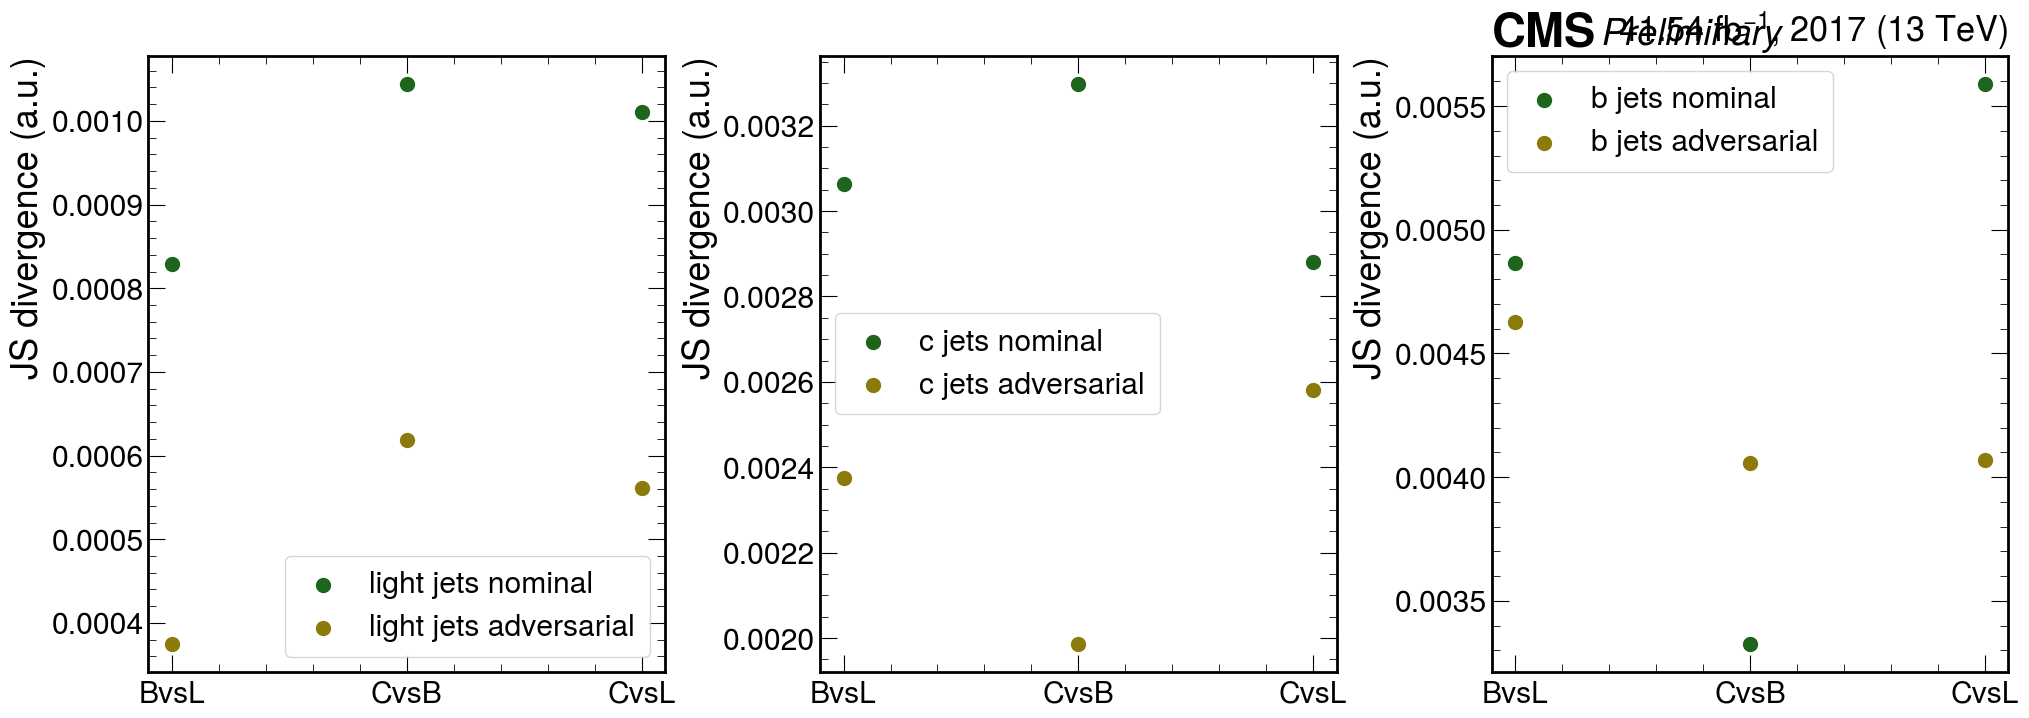

In [64]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
fig.subplots_adjust(wspace = 0.3)
#fig.tight_layout()
ax1.scatter(xses, js_divs_all_basic_DY, label='light jets nominal'   , s=100 )
ax1.scatter(xses, js_divs_all_adv_DY, label='light jets adversarial' , s=100 )
ax2.scatter(xses, js_divs_all_basic_Wc, label='c jets nominal'       , s=100 )
ax2.scatter(xses, js_divs_all_adv_Wc, label='c jets adversarial'     , s=100 )
ax3.scatter(xses, js_divs_all_basic_TT, label='b jets nominal'       , s=100 )
ax3.scatter(xses, js_divs_all_adv_TT, label='b jets adversarial'     , s=100 )
ax1.legend(frameon=True)
ax2.legend(frameon=True)
ax3.legend(frameon=True)
ax1.set_ylabel('JS divergence (a.u.)')
ax2.set_ylabel('JS divergence (a.u.)')
ax3.set_ylabel('JS divergence (a.u.)')
hep.cms.label('Preliminary', data=True, lumi=41.54, year=2017)###fig.suptitle('JS divergence. Best epoch.', y=0.95)
#fig.savefig('js_best_epoch_custom_DeepJet_forRTG.pdf')

In [65]:
plt.rcParams['axes.axisbelow'] = True

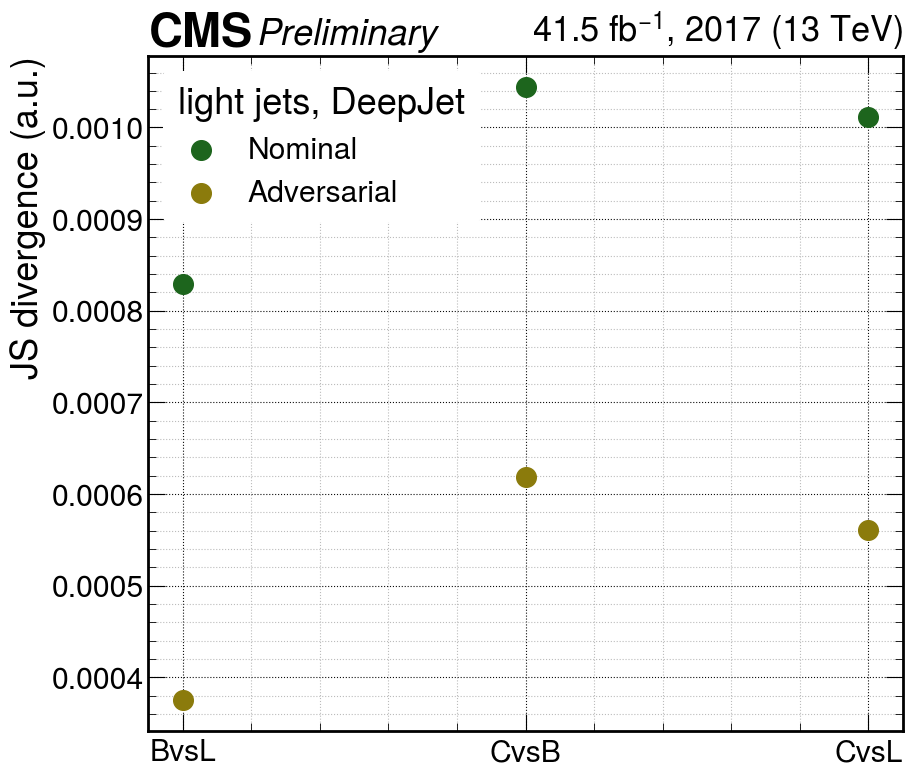

In [66]:
#fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
fig, ax1 = plt.subplots(1, figsize=(9,8))
#fig.subplots_adjust(wspace = 0.3)
fig.tight_layout()
ax1.grid(which='minor', alpha=0.85)
ax1.grid(which='major', alpha=0.95, color='black')
ax1.scatter(xses, js_divs_all_basic_DY, label='Nominal'   , s=200 )
ax1.scatter(xses, js_divs_all_adv_DY, label='Adversarial' , s=200 )
#ax2.scatter(xses, js_divs_all_basic_Wc, label='c jets nominal'       , s=100 )
#ax2.scatter(xses, js_divs_all_adv_Wc, label='c jets adversarial'     , s=100 )
#ax3.scatter(xses, js_divs_all_basic_TT, label='b jets nominal'       , s=100 )
#ax3.scatter(xses, js_divs_all_adv_TT, label='b jets adversarial'     , s=100 )
#ax1.legend(frameon=True, title='Light jets')
ax1.legend(frameon=True, framealpha=1, title='light jets, DeepJet')
leg = ax1.get_legend()
leg._legend_box.align = "left"
leg.get_frame().set_linewidth(0.0)
#ax2.legend(frameon=True)
#ax3.legend(frameon=True)
ax1.set_ylabel('JS divergence (a.u.)')
#ax2.set_ylabel('JS divergence (a.u.)')
#ax3.set_ylabel('JS divergence (a.u.)')
hep.cms.label('Preliminary', data=True, lumi=41.5, year=2017)###fig.suptitle('JS divergence. Best epoch.', y=0.95)
#fig.savefig('js_best_epoch_custom_DeepJet_LIGHT_v2.pdf', bbox_inches='tight')
fig.savefig('js_best_epoch_custom_DeepJet_LIGHT_v2_30bins_v4.pdf', bbox_inches='tight')

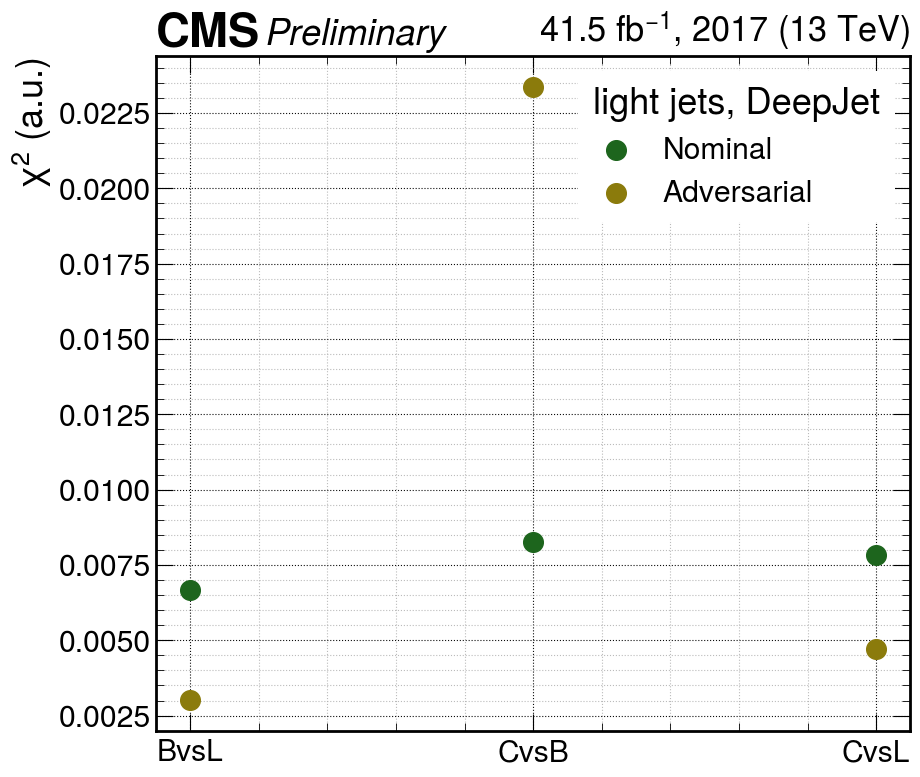

In [67]:
#fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
fig, ax1 = plt.subplots(1, figsize=(9,8))
#fig.subplots_adjust(wspace = 0.3)
fig.tight_layout()
ax1.grid(which='minor', alpha=0.85)
ax1.grid(which='major', alpha=0.95, color='black')
ax1.scatter(xses, chi2_all_basic_DY, label='Nominal'   , s=200 )
ax1.scatter(xses, chi2_all_adv_DY, label='Adversarial' , s=200 )
#ax2.scatter(xses, js_divs_all_basic_Wc, label='c jets nominal'       , s=100 )
#ax2.scatter(xses, js_divs_all_adv_Wc, label='c jets adversarial'     , s=100 )
#ax3.scatter(xses, js_divs_all_basic_TT, label='b jets nominal'       , s=100 )
#ax3.scatter(xses, js_divs_all_adv_TT, label='b jets adversarial'     , s=100 )
#ax1.legend(frameon=True, title='Light jets')
ax1.legend(frameon=True, framealpha=1, title='light jets, DeepJet')
leg = ax1.get_legend()
leg._legend_box.align = "left"
leg.get_frame().set_linewidth(0.0)
#ax2.legend(frameon=True)
#ax3.legend(frameon=True)
ax1.set_ylabel(r'$\chi^2$ (a.u.)')
#ax2.set_ylabel('JS divergence (a.u.)')
#ax3.set_ylabel('JS divergence (a.u.)')
hep.cms.label('Preliminary', data=True, lumi=41.5, year=2017)###fig.suptitle('JS divergence. Best epoch.', y=0.95)
#fig.savefig('chi2_best_epoch_custom_DeepJet_LIGHT_v2.pdf', bbox_inches='tight')
fig.savefig('chi2_best_epoch_custom_DeepJet_LIGHT_v2_30bins_v4.pdf', bbox_inches='tight')

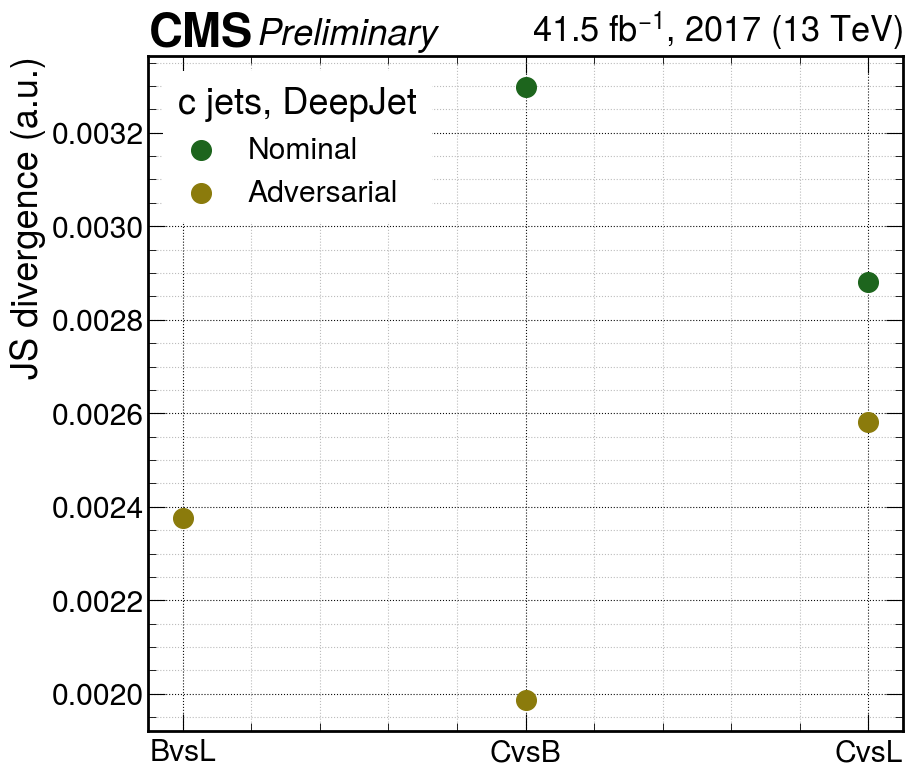

In [68]:
#fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
fig, ax2 = plt.subplots(1, figsize=(9,8))
#fig.subplots_adjust(wspace = 0.3)
fig.tight_layout()
ax2.grid(which='minor', alpha=0.85)
ax2.grid(which='major', alpha=0.95, color='black')
#ax1.scatter(xses, js_divs_all_basic_DY, label='light jets nominal'   , s=100 )
#ax1.scatter(xses, js_divs_all_adv_DY, label='light jets adversarial' , s=100 )
ax2.scatter(xses, js_divs_all_basic_Wc, label='Nominal'       , s=200 )
ax2.scatter(xses, js_divs_all_adv_Wc, label='Adversarial'     , s=200 )
#ax3.scatter(xses, js_divs_all_basic_TT, label='b jets nominal'       , s=100 )
#ax3.scatter(xses, js_divs_all_adv_TT, label='b jets adversarial'     , s=100 )
#ax1.legend(frameon=True)
ax2.legend(frameon=True, framealpha=1, title='c jets, DeepJet', loc="upper left")
leg = ax2.get_legend()
leg._legend_box.align = "left"
leg.get_frame().set_linewidth(0.0)
#ax3.legend(frameon=True)
#ax1.set_ylabel('JS divergence (a.u.)')
ax2.set_ylabel('JS divergence (a.u.)')
#ax3.set_ylabel('JS divergence (a.u.)')
hep.cms.label('Preliminary', data=True, lumi=41.5, year=2017)###fig.suptitle('JS divergence. Best epoch.', y=0.95)
#fig.savefig('js_best_epoch_custom_DeepJet_CHARM_v2.pdf', bbox_inches='tight')
fig.savefig('js_best_epoch_custom_DeepJet_CHARM_v2_30bins_v4.pdf', bbox_inches='tight')

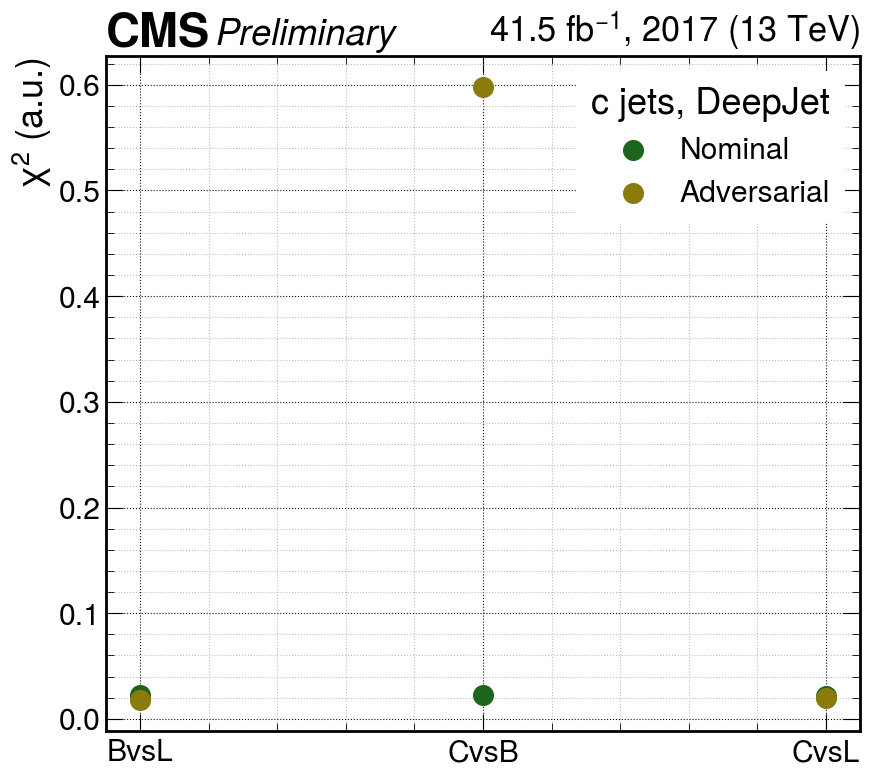

In [69]:
#fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
fig, ax2 = plt.subplots(1, figsize=(9,8))
#fig.subplots_adjust(wspace = 0.3)
fig.tight_layout()
ax2.grid(which='minor', alpha=0.85)
ax2.grid(which='major', alpha=0.95, color='black')
#ax1.scatter(xses, js_divs_all_basic_DY, label='light jets nominal'   , s=100 )
#ax1.scatter(xses, js_divs_all_adv_DY, label='light jets adversarial' , s=100 )
ax2.scatter(xses, chi2_all_basic_Wc, label='Nominal'       , s=200 )
ax2.scatter(xses, chi2_all_adv_Wc, label='Adversarial'     , s=200 )
#ax3.scatter(xses, js_divs_all_basic_TT, label='b jets nominal'       , s=100 )
#ax3.scatter(xses, js_divs_all_adv_TT, label='b jets adversarial'     , s=100 )
#ax1.legend(frameon=True)
ax2.legend(frameon=True, framealpha=1, title='c jets, DeepJet', loc="upper right")
leg = ax2.get_legend()
leg._legend_box.align = "right"
leg.get_frame().set_linewidth(0.0)
#ax3.legend(frameon=True)
#ax1.set_ylabel('JS divergence (a.u.)')
ax2.set_ylabel(r'$\chi^2$ (a.u.)')
#ax3.set_ylabel('JS divergence (a.u.)')
hep.cms.label('Preliminary', data=True, lumi=41.5, year=2017)###fig.suptitle('JS divergence. Best epoch.', y=0.95)
#fig.savefig('chi2_best_epoch_custom_DeepJet_CHARM_v2.pdf', bbox_inches='tight')
fig.savefig('chi2_best_epoch_custom_DeepJet_CHARM_v2_30bins_v4.pdf', bbox_inches='tight')

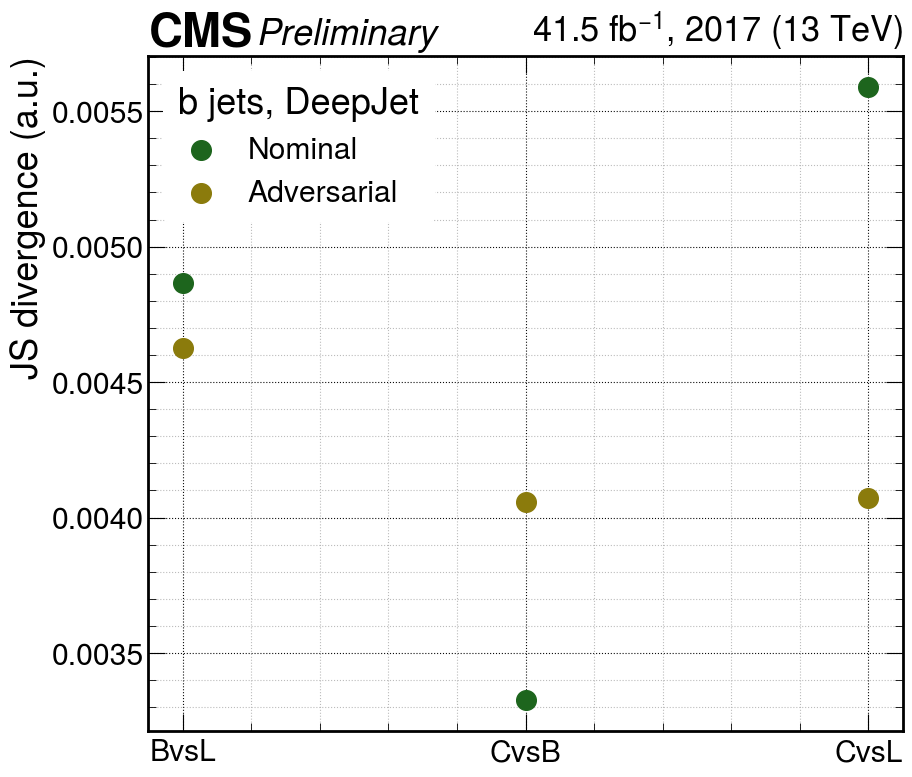

In [70]:
#fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
fig, ax3 = plt.subplots(1, figsize=(9,8))
#fig.subplots_adjust(wspace = 0.3)
fig.tight_layout()
ax3.grid(which='minor', alpha=0.85)
ax3.grid(which='major', alpha=0.95, color='black')
#ax1.scatter(xses, js_divs_all_basic_DY, label='light jets nominal'   , s=100 )
#ax1.scatter(xses, js_divs_all_adv_DY, label='light jets adversarial' , s=100 )
#ax2.scatter(xses, js_divs_all_basic_Wc, label='c jets nominal'       , s=100 )
#ax2.scatter(xses, js_divs_all_adv_Wc, label='c jets adversarial'     , s=100 )
ax3.scatter(xses, js_divs_all_basic_TT, label='Nominal'       , s=200 )
ax3.scatter(xses, js_divs_all_adv_TT, label='Adversarial'     , s=200 )
#ax1.legend(frameon=True)
#ax2.legend(frameon=True)
ax3.legend(frameon=True, framealpha=1, title='b jets, DeepJet')
leg = ax3.get_legend()
leg._legend_box.align = "left"
leg.get_frame().set_linewidth(0.0)
#ax1.set_ylabel('JS divergence (a.u.)')
#ax2.set_ylabel('JS divergence (a.u.)')
ax3.set_ylabel('JS divergence (a.u.)')
hep.cms.label('Preliminary', data=True, lumi=41.5, year=2017)###fig.suptitle('JS divergence. Best epoch.', y=0.95)
#fig.savefig('js_best_epoch_custom_DeepJet_BOTTOM_v2.pdf', bbox_inches='tight')
fig.savefig('js_best_epoch_custom_DeepJet_BOTTOM_v2_30bins_v4.pdf', bbox_inches='tight')

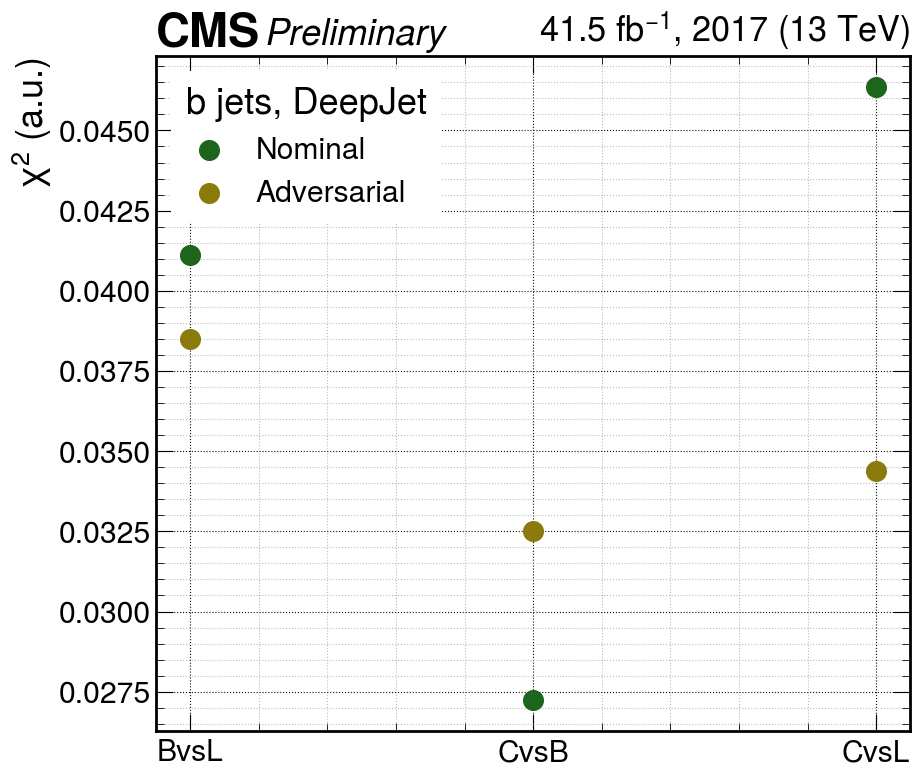

In [71]:
#fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
fig, ax3 = plt.subplots(1, figsize=(9,8))
#fig.subplots_adjust(wspace = 0.3)
fig.tight_layout()
ax3.grid(which='minor', alpha=0.85)
ax3.grid(which='major', alpha=0.95, color='black')
#ax1.scatter(xses, js_divs_all_basic_DY, label='light jets nominal'   , s=100 )
#ax1.scatter(xses, js_divs_all_adv_DY, label='light jets adversarial' , s=100 )
#ax2.scatter(xses, js_divs_all_basic_Wc, label='c jets nominal'       , s=100 )
#ax2.scatter(xses, js_divs_all_adv_Wc, label='c jets adversarial'     , s=100 )
ax3.scatter(xses, chi2_all_basic_TT, label='Nominal'       , s=200 )
ax3.scatter(xses, chi2_all_adv_TT, label='Adversarial'     , s=200 )
#ax1.legend(frameon=True)
#ax2.legend(frameon=True)
ax3.legend(frameon=True, framealpha=1, title='b jets, DeepJet')
leg = ax3.get_legend()
leg._legend_box.align = "left"
leg.get_frame().set_linewidth(0.0)
#ax1.set_ylabel('JS divergence (a.u.)')
#ax2.set_ylabel('JS divergence (a.u.)')
ax3.set_ylabel(r'$\chi^2$ (a.u.)')
hep.cms.label('Preliminary', data=True, lumi=41.5, year=2017)###fig.suptitle('JS divergence. Best epoch.', y=0.95)
#fig.savefig('chi2_best_epoch_custom_DeepJet_BOTTOM_v2.pdf', bbox_inches='tight')
fig.savefig('chi2_best_epoch_custom_DeepJet_BOTTOM_v2_30bins_v4.pdf', bbox_inches='tight')

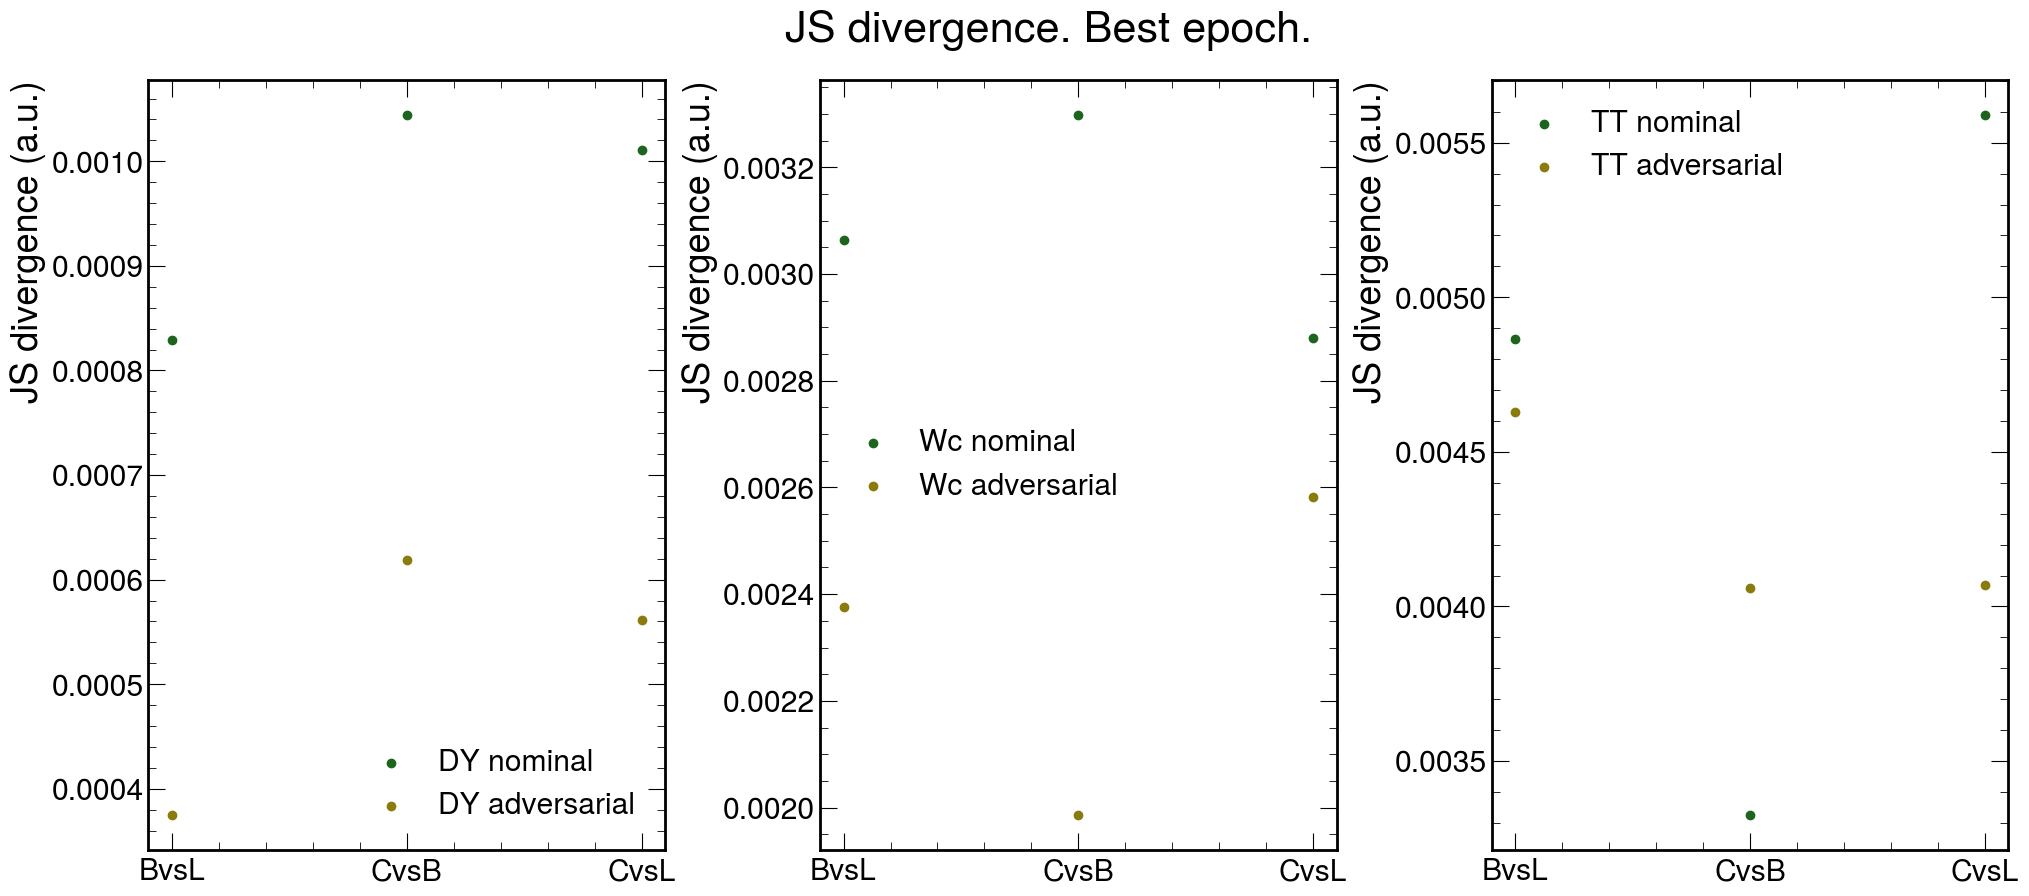

In [72]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,10))
fig.subplots_adjust(wspace = 0.3)
#fig.tight_layout()
ax1.scatter(xses, js_divs_all_basic_DY, label='DY nominal')
ax1.scatter(xses, js_divs_all_adv_DY, label='DY adversarial')
ax2.scatter(xses, js_divs_all_basic_Wc, label='Wc nominal')
ax2.scatter(xses, js_divs_all_adv_Wc, label='Wc adversarial')
ax3.scatter(xses, js_divs_all_basic_TT, label='TT nominal')
ax3.scatter(xses, js_divs_all_adv_TT, label='TT adversarial')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_ylabel('JS divergence (a.u.)')
ax2.set_ylabel('JS divergence (a.u.)')
ax3.set_ylabel('JS divergence (a.u.)')
fig.suptitle('JS divergence. Best epoch.', y=0.95)
#fig.savefig('js_best_epoch_custom_DeepJet.pdf')
fig.savefig('js_best_epoch_custom_DeepJet_30bins_v4.pdf')

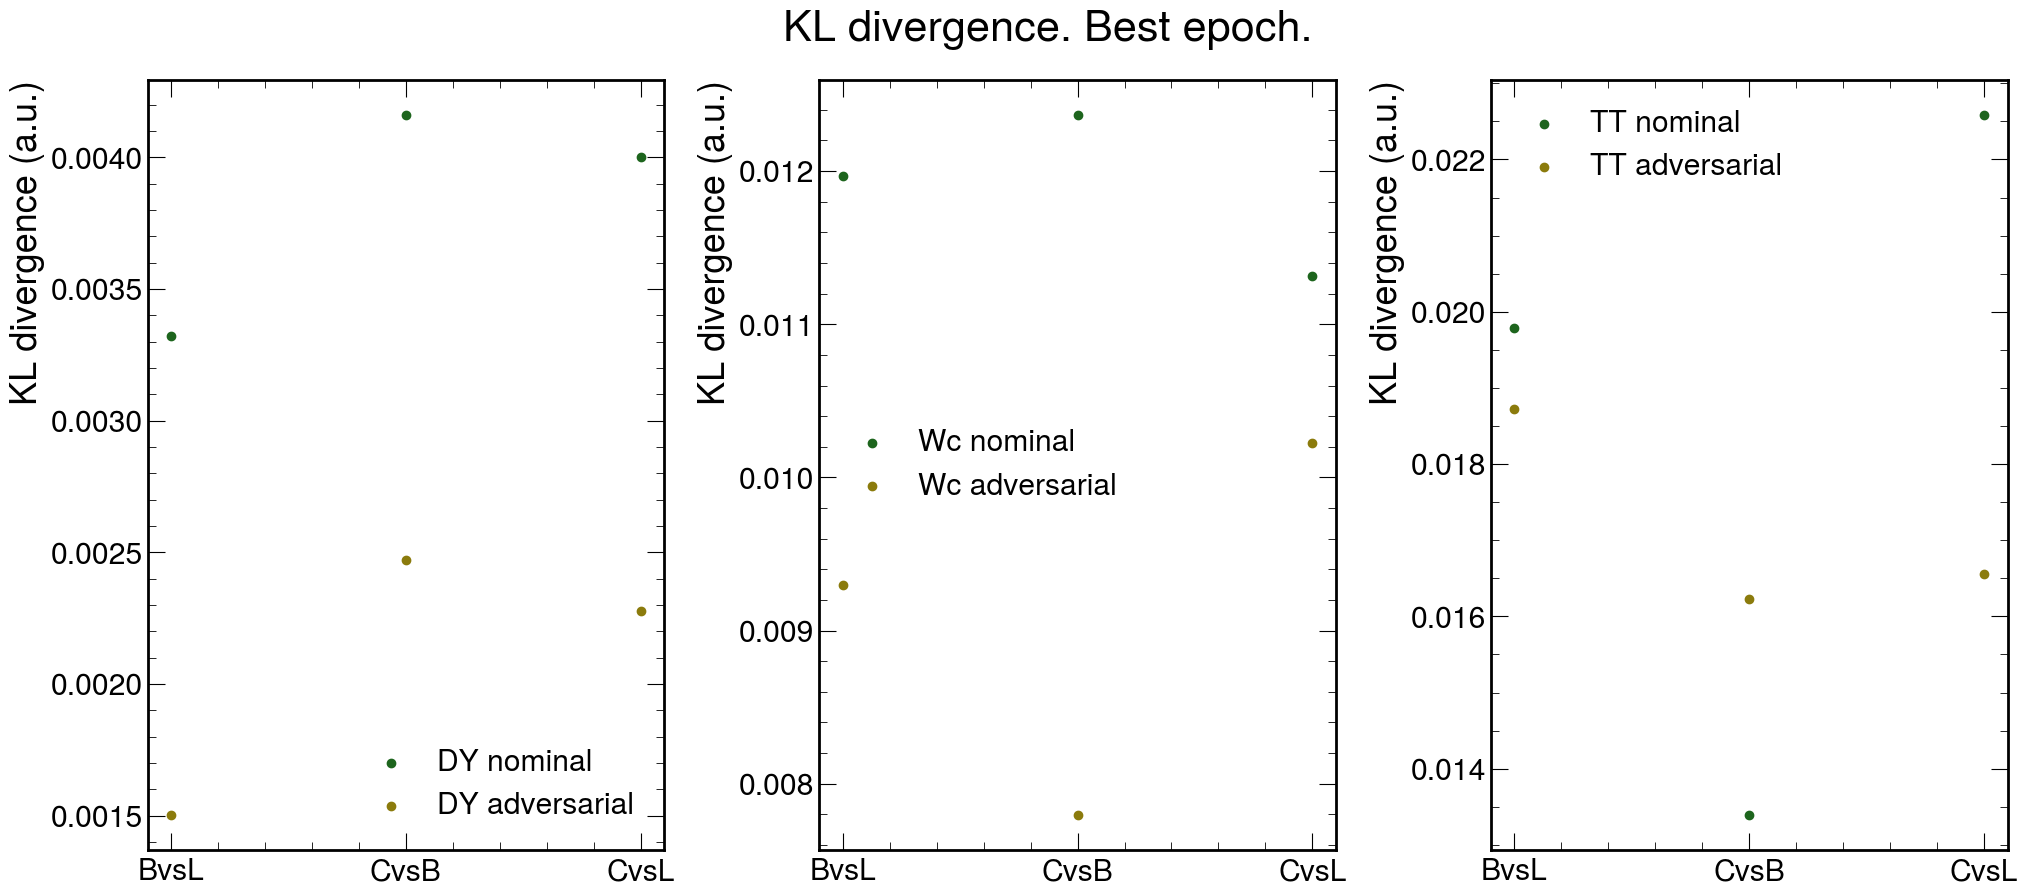

In [73]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,10))
fig.subplots_adjust(wspace = 0.3)
#fig.tight_layout()
ax1.scatter(xses, kl_divs_all_basic_DY, label='DY nominal')
ax1.scatter(xses, kl_divs_all_adv_DY, label='DY adversarial')
ax2.scatter(xses, kl_divs_all_basic_Wc, label='Wc nominal')
ax2.scatter(xses, kl_divs_all_adv_Wc, label='Wc adversarial')
ax3.scatter(xses, kl_divs_all_basic_TT, label='TT nominal')
ax3.scatter(xses, kl_divs_all_adv_TT, label='TT adversarial')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_ylabel('KL divergence (a.u.)')
ax2.set_ylabel('KL divergence (a.u.)')
ax3.set_ylabel('KL divergence (a.u.)')
fig.suptitle('KL divergence. Best epoch.', y=0.95)
#fig.savefig('kl_best_epoch_custom_DeepJet.pdf')
fig.savefig('kl_best_epoch_custom_DeepJet_30bins_v4.pdf')

$\chi$

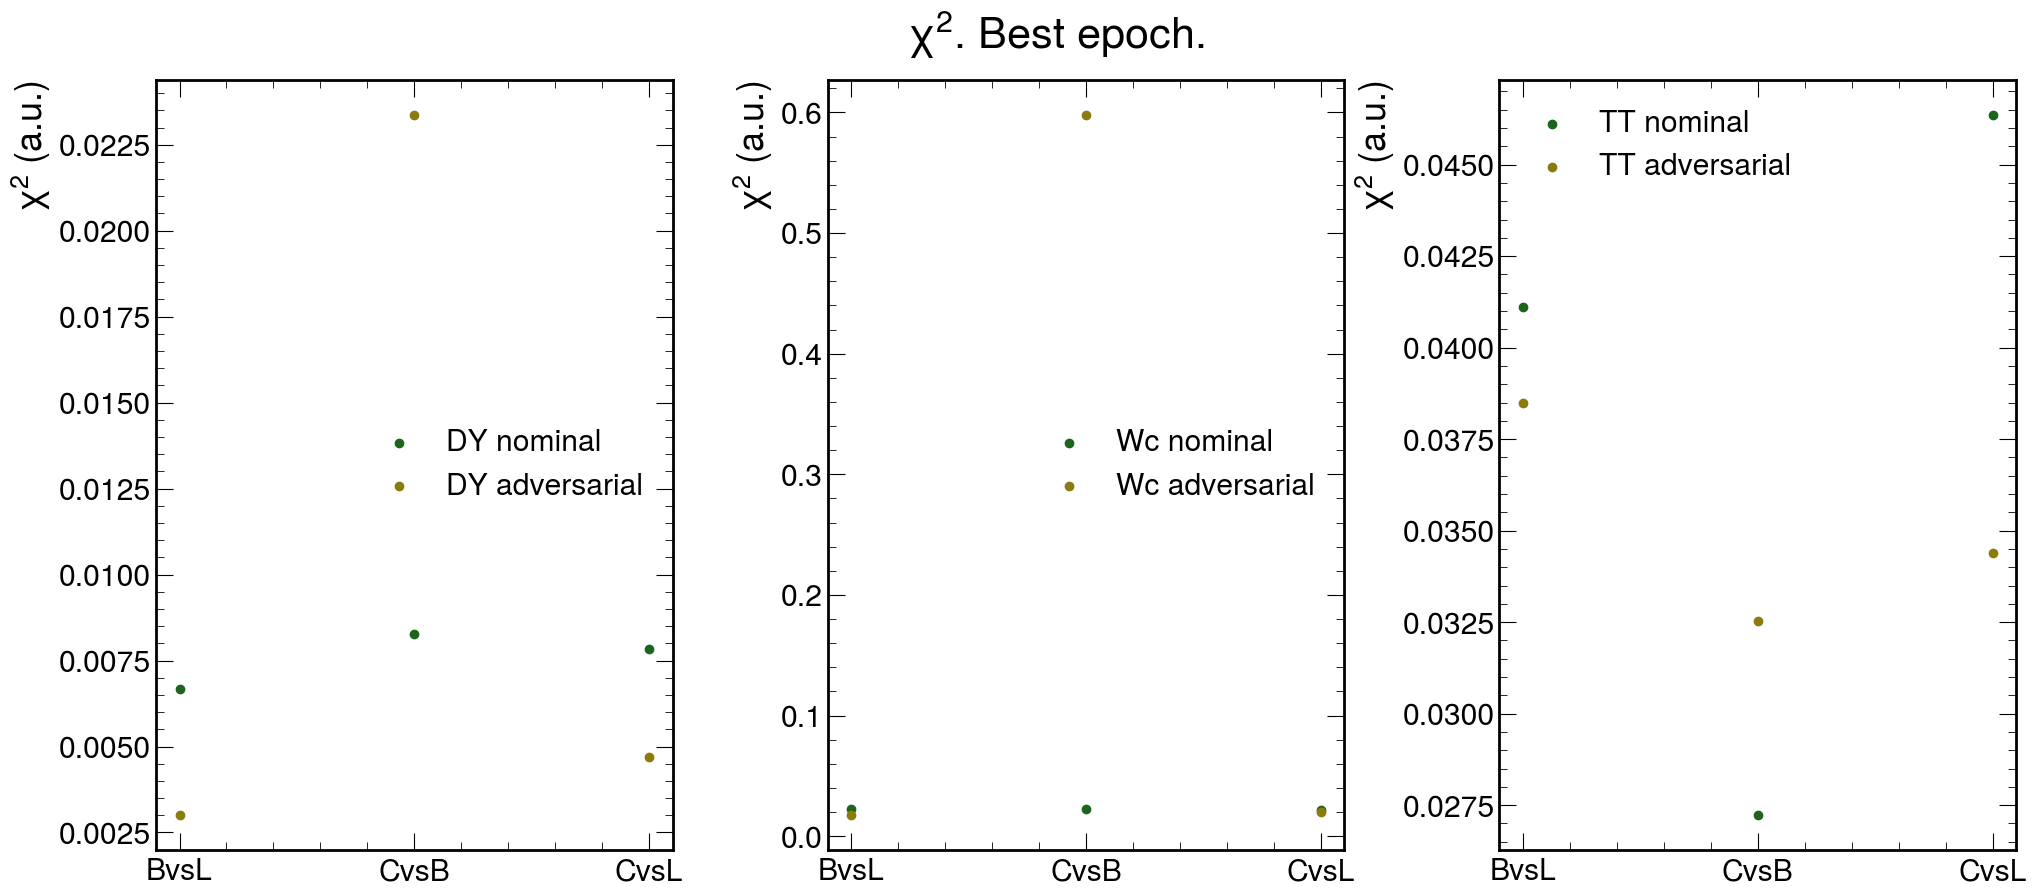

In [74]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,10))
fig.subplots_adjust(wspace = 0.3)
#fig.tight_layout()
ax1.scatter(xses, chi2_all_basic_DY, label='DY nominal')
ax1.scatter(xses, chi2_all_adv_DY, label='DY adversarial')
ax2.scatter(xses, chi2_all_basic_Wc, label='Wc nominal')
ax2.scatter(xses, chi2_all_adv_Wc, label='Wc adversarial')
ax3.scatter(xses, chi2_all_basic_TT, label='TT nominal')
ax3.scatter(xses, chi2_all_adv_TT, label='TT adversarial')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_ylabel(r'$\chi^2$ (a.u.)')
ax2.set_ylabel(r'$\chi^2$ (a.u.)')
ax3.set_ylabel(r'$\chi^2$ (a.u.)')
fig.suptitle(r'$\mathcal{\chi^2}$. Best epoch.', y=0.95)
#fig.savefig('chi2_best_epoch_custom_DeepJet.pdf')
fig.savefig('chi2_best_epoch_custom_DeepJet_30bins_v4.pdf')

In [75]:
#!tar czf JS_divs_2022_09_15.tar.gz JS_divergences/*.svg